# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

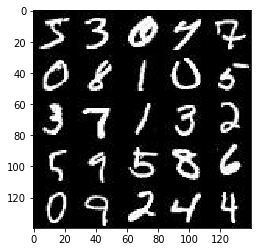

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

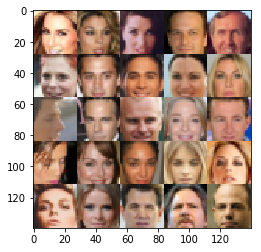

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [13]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    real_param = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='real_param')
    z_param = tf.placeholder(tf.float32, (None, z_dim), name='z_param')
    learning_rate_param = tf.placeholder(tf.float32, name='learning_rate_param')

    return real_param, z_param, learning_rate_param


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [142]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope('discriminator', reuse=reuse):
        a = 0.1
        dropout = 0.2
        
        input_layer = tf.layers.conv2d(images, 64, 5, strides=2, padding='same', 
                                      kernel_initializer=tf.contrib.layers.xavier_initializer())
        input_layer = tf.maximum(a * input_layer, input_layer) #relu
        
        hiden_layer_1 = tf.layers.conv2d(input_layer, 128, 5, strides=2, padding='same',
                                        kernel_initializer=tf.contrib.layers.xavier_initializer())
        #hiden_layer_1 = tf.layers.dropout(hiden_layer_1, rate=dropout, training=True)
        hiden_layer_1 = tf.layers.batch_normalization(hiden_layer_1, training=True) 
        hiden_layer_1 = tf.maximum(hiden_layer_1 * a, hiden_layer_1) #relu
        
        hiden_layer_2 = tf.layers.conv2d(hiden_layer_1, 256, 5, strides=2, padding='same', 
                                        kernel_initializer=tf.contrib.layers.xavier_initializer())
        #hiden_layer_2 = tf.layers.dropout(hiden_layer_2, rate=dropout, training=True)
        hiden_layer_2 = tf.layers.batch_normalization(hiden_layer_2, training=True)
        hiden_layer_2 = tf.maximum(hiden_layer_2 * a, hiden_layer_2) #relu
        
        flat = tf.reshape(hiden_layer_2, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        output_layer = tf.sigmoid(logits)

    return output_layer, logits

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [140]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    with tf.variable_scope('generator', reuse=not is_train):
        a = 0.1
        dropout = 0.2
        
        # project and reshape
        input_layer = tf.layers.dense(z, 7*7*512)
        input_layer = tf.reshape(input_layer, (-1, 7, 7, 512))
        
        hiden_layer_1 = tf.layers.batch_normalization(input_layer, training=is_train)
        hiden_layer_1 = tf.maximum(hiden_layer_1 * a, hiden_layer_1)
        #output: 7x7x512
        
        hiden_layer_2 = tf.layers.conv2d_transpose(hiden_layer_1, 256, 1, strides=1, padding='same', 
                                                  kernel_initializer=tf.contrib.layers.xavier_initializer())
        #hiden_layer_2 = tf.layers.dropout(hiden_layer_2, rate=dropout, training=True)
        hiden_layer_2 = tf.layers.batch_normalization(hiden_layer_2, training=is_train)
        hiden_layer_2 = tf.maximum(hiden_layer_2 * a, hiden_layer_2)
        #output: 7x7x256
        
        hiden_layer_3 = tf.layers.conv2d_transpose(hiden_layer_2, 128, 3, strides=2, padding='same', 
                                                  kernel_initializer=tf.contrib.layers.xavier_initializer())
        #hiden_layer_3 = tf.layers.dropout(hiden_layer_3, rate=dropout, training=True)
        hiden_layer_3 = tf.layers.batch_normalization(hiden_layer_3, training=is_train)
        hiden_layer_3 = tf.maximum(hiden_layer_3 * a, hiden_layer_3)
        #output: 14x14x128
        
        hiden_layer_4 = tf.layers.conv2d_transpose(hiden_layer_3, 64, 1, strides=1, padding='same', 
                                                  kernel_initializer=tf.contrib.layers.xavier_initializer())
        #hiden_layer_4 = tf.layers.dropout(hiden_layer_4, rate=dropout, training=True)
        hiden_layer_4 = tf.layers.batch_normalization(hiden_layer_4, training=is_train)
        hiden_layer_4 = tf.maximum(hiden_layer_4 * a, hiden_layer_4)
        #output: 14x14x64
               
        logits = tf.layers.conv2d_transpose(hiden_layer_4, out_channel_dim, 3, strides=2, padding='same', 
                                           kernel_initializer=tf.contrib.layers.xavier_initializer())
        output = tf.tanh(logits)
        #output: 28x28xout_channel_dim
        
    return output


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [150]:
def loss(logits, labels):
    loss = tf.reduce_mean(
                tf.nn.sigmoid_cross_entropy_with_logits(
                        logits=logits, labels=labels))
    return loss

def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    smooth = 0.09
    generator_model = generator(input_z, out_channel_dim, is_train=True)
    discriminator_model, discriminator_logits = discriminator(input_real, reuse=False)
    discriminator_fake_model, discriminator_fake_logits = discriminator(generator_model, reuse=True)
    
    discriminator_loss_real = loss(discriminator_logits, tf.ones_like(discriminator_model) * (1 - smooth))
    discriminator_loss_fake = loss(discriminator_fake_logits, tf.zeros_like(discriminator_fake_model))
    
    total_discriminator_loss = discriminator_loss_real + discriminator_loss_fake
    generator_loss = loss(discriminator_fake_logits, tf.ones_like(discriminator_fake_model))
    
    return total_discriminator_loss, generator_loss



"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [82]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    trained_vars = tf.trainable_variables()
    generator_vars = [var for var in trained_vars if var.name.startswith('generator')]
    discriminator_vars = [var for var in trained_vars if var.name.startswith('discriminator')]
    
    update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    generator_update_ops = [var for var in update_ops if var.name.startswith('generator')]
    discriminator_update_ops = [var for var in update_ops if var.name.startswith('discriminator')]
    
    with tf.control_dependencies(discriminator_update_ops):
        discriminator_train_optimizer = tf.train.AdamOptimizer(
            learning_rate, beta1=beta1).minimize(
                d_loss, var_list=discriminator_vars)
        
    with tf.control_dependencies(generator_update_ops):
        generator_train_optimizer = tf.train.AdamOptimizer(
            learning_rate, beta1=beta1).minimize(
                g_loss, var_list=generator_vars)
    
    return discriminator_train_optimizer, generator_train_optimizer


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [83]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [85]:
import matplotlib.pyplot as plt

def show_GAN_losses(losses):
    fig, ax = plt.subplots()
    losses = np.array(losses)
    plt.plot(losses.T[0], label='Discriminator')
    plt.plot(losses.T[1], label='Generator')
    plt.title("Training Losses")
    plt.legend()

def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    losses = []
    step = 0
    
    _, image_width, image_height, image_channels = data_shape
        
    input_real, input_z, lrate = model_inputs(image_width,image_height,image_channels,z_dim)
    
    discriminator_loss, generator_loss = model_loss(input_real, input_z, image_channels)
    discriminator_train_optimizer, generator_train_optimizer = model_opt(
        discriminator_loss, generator_loss, learning_rate, beta1) 

    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                step = step + 1
                batch_images = batch_images.reshape(batch_size, image_width, image_height, image_channels)
                batch_images = batch_images * 2
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))               
                _ = sess.run(discriminator_train_optimizer, 
                             feed_dict={input_real: batch_images,input_z: batch_z,lrate:learning_rate})
                _ = sess.run(generator_train_optimizer, 
                             feed_dict={input_real: batch_images,input_z: batch_z,lrate:learning_rate})
                if step % 10 == 0:
                    train_loss_discriminator = discriminator_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_generator = generator_loss.eval({input_z: batch_z})
                    print("epoch {} of {} -".format(epoch_i+1, epochs),
                          "generator loss: {:.3f}".format(train_loss_generator),
                          "discriminator loss: {:.3f} ".format(train_loss_discriminator))
                    # keep losses to view after training
                    losses.append((train_loss_discriminator, train_loss_generator))
                          
                if step % 100 == 0:
                    show_generator_output(sess, 25, input_z, image_channels, data_image_mode)
                    
        print("Final output:")
        show_generator_output(sess, 25, input_z, image_channels, data_image_mode)
    
    show_GAN_losses(losses)
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

epoch 1 of 2 - generator loss: 3.049 discriminator loss: 0.565 
epoch 1 of 2 - generator loss: 0.860 discriminator loss: 1.640 
epoch 1 of 2 - generator loss: 0.140 discriminator loss: 2.916 
epoch 1 of 2 - generator loss: 1.034 discriminator loss: 1.097 
epoch 1 of 2 - generator loss: 1.618 discriminator loss: 1.212 
epoch 1 of 2 - generator loss: 0.193 discriminator loss: 2.195 
epoch 1 of 2 - generator loss: 0.436 discriminator loss: 1.622 
epoch 1 of 2 - generator loss: 0.443 discriminator loss: 1.635 
epoch 1 of 2 - generator loss: 0.870 discriminator loss: 1.348 
epoch 1 of 2 - generator loss: 1.218 discriminator loss: 1.196 


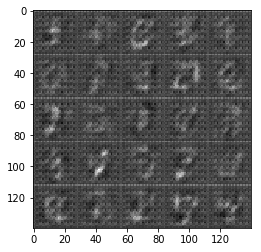

epoch 1 of 2 - generator loss: 2.547 discriminator loss: 1.957 
epoch 1 of 2 - generator loss: 0.964 discriminator loss: 1.119 
epoch 1 of 2 - generator loss: 2.098 discriminator loss: 1.482 
epoch 1 of 2 - generator loss: 0.849 discriminator loss: 1.166 
epoch 1 of 2 - generator loss: 1.539 discriminator loss: 1.173 
epoch 1 of 2 - generator loss: 0.829 discriminator loss: 1.095 
epoch 1 of 2 - generator loss: 0.094 discriminator loss: 3.188 
epoch 1 of 2 - generator loss: 0.919 discriminator loss: 1.087 
epoch 1 of 2 - generator loss: 2.044 discriminator loss: 1.349 
epoch 1 of 2 - generator loss: 0.342 discriminator loss: 1.901 


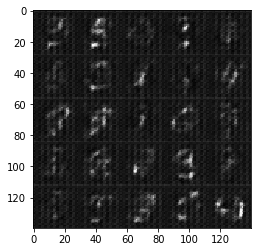

epoch 1 of 2 - generator loss: 1.694 discriminator loss: 1.109 
epoch 1 of 2 - generator loss: 1.876 discriminator loss: 0.858 
epoch 1 of 2 - generator loss: 0.402 discriminator loss: 1.556 
epoch 1 of 2 - generator loss: 0.554 discriminator loss: 1.384 
epoch 1 of 2 - generator loss: 0.358 discriminator loss: 1.748 
epoch 1 of 2 - generator loss: 1.020 discriminator loss: 0.939 
epoch 1 of 2 - generator loss: 0.803 discriminator loss: 1.118 
epoch 1 of 2 - generator loss: 0.628 discriminator loss: 1.323 
epoch 1 of 2 - generator loss: 1.739 discriminator loss: 1.445 
epoch 1 of 2 - generator loss: 0.254 discriminator loss: 1.972 


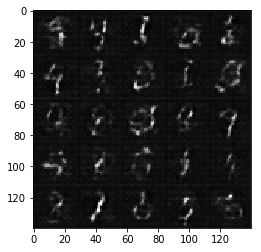

epoch 1 of 2 - generator loss: 1.037 discriminator loss: 0.955 
epoch 1 of 2 - generator loss: 0.937 discriminator loss: 1.157 
epoch 1 of 2 - generator loss: 0.352 discriminator loss: 1.658 
epoch 1 of 2 - generator loss: 0.472 discriminator loss: 1.483 
epoch 1 of 2 - generator loss: 1.474 discriminator loss: 0.917 
epoch 1 of 2 - generator loss: 0.606 discriminator loss: 1.332 
epoch 1 of 2 - generator loss: 1.092 discriminator loss: 1.364 
epoch 1 of 2 - generator loss: 0.789 discriminator loss: 1.166 
epoch 1 of 2 - generator loss: 0.739 discriminator loss: 1.228 
epoch 1 of 2 - generator loss: 0.255 discriminator loss: 1.966 


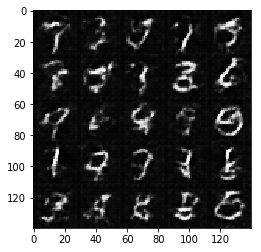

epoch 1 of 2 - generator loss: 0.285 discriminator loss: 1.853 
epoch 1 of 2 - generator loss: 1.505 discriminator loss: 0.839 
epoch 1 of 2 - generator loss: 0.379 discriminator loss: 1.706 
epoch 1 of 2 - generator loss: 0.477 discriminator loss: 1.449 
epoch 1 of 2 - generator loss: 1.028 discriminator loss: 1.003 
epoch 1 of 2 - generator loss: 1.478 discriminator loss: 1.192 
epoch 1 of 2 - generator loss: 0.688 discriminator loss: 1.226 
epoch 1 of 2 - generator loss: 1.553 discriminator loss: 1.125 
epoch 1 of 2 - generator loss: 0.672 discriminator loss: 1.261 
epoch 1 of 2 - generator loss: 0.399 discriminator loss: 1.588 


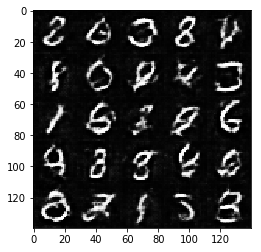

epoch 1 of 2 - generator loss: 0.992 discriminator loss: 1.094 
epoch 1 of 2 - generator loss: 0.666 discriminator loss: 1.298 
epoch 1 of 2 - generator loss: 0.456 discriminator loss: 1.492 
epoch 1 of 2 - generator loss: 0.442 discriminator loss: 1.572 
epoch 1 of 2 - generator loss: 2.006 discriminator loss: 1.455 
epoch 1 of 2 - generator loss: 1.192 discriminator loss: 1.277 
epoch 1 of 2 - generator loss: 1.834 discriminator loss: 1.233 
epoch 1 of 2 - generator loss: 1.438 discriminator loss: 1.135 
epoch 1 of 2 - generator loss: 1.466 discriminator loss: 0.927 
epoch 1 of 2 - generator loss: 0.424 discriminator loss: 1.653 


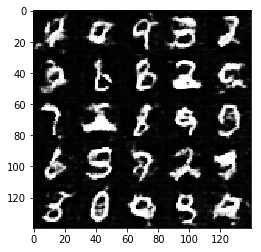

epoch 1 of 2 - generator loss: 1.000 discriminator loss: 1.144 
epoch 1 of 2 - generator loss: 0.672 discriminator loss: 1.223 
epoch 1 of 2 - generator loss: 0.423 discriminator loss: 1.580 
epoch 1 of 2 - generator loss: 0.997 discriminator loss: 1.058 
epoch 1 of 2 - generator loss: 0.818 discriminator loss: 1.142 
epoch 1 of 2 - generator loss: 0.568 discriminator loss: 1.344 
epoch 1 of 2 - generator loss: 0.972 discriminator loss: 1.132 
epoch 1 of 2 - generator loss: 1.643 discriminator loss: 0.760 
epoch 1 of 2 - generator loss: 0.776 discriminator loss: 1.176 
epoch 1 of 2 - generator loss: 1.056 discriminator loss: 0.868 


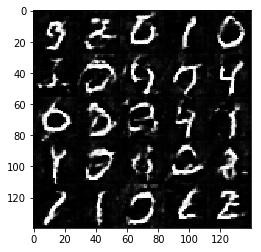

epoch 1 of 2 - generator loss: 0.338 discriminator loss: 1.709 
epoch 1 of 2 - generator loss: 0.530 discriminator loss: 1.445 
epoch 1 of 2 - generator loss: 0.836 discriminator loss: 1.127 
epoch 1 of 2 - generator loss: 0.709 discriminator loss: 1.137 
epoch 1 of 2 - generator loss: 1.630 discriminator loss: 1.016 
epoch 1 of 2 - generator loss: 0.745 discriminator loss: 1.182 
epoch 1 of 2 - generator loss: 0.412 discriminator loss: 1.623 
epoch 1 of 2 - generator loss: 0.516 discriminator loss: 1.400 
epoch 1 of 2 - generator loss: 0.690 discriminator loss: 1.278 
epoch 1 of 2 - generator loss: 0.263 discriminator loss: 1.875 


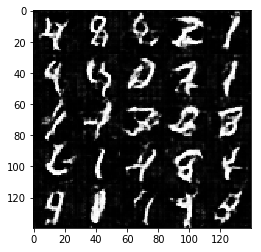

epoch 1 of 2 - generator loss: 1.151 discriminator loss: 0.846 
epoch 1 of 2 - generator loss: 0.536 discriminator loss: 1.418 
epoch 1 of 2 - generator loss: 0.187 discriminator loss: 2.273 
epoch 1 of 2 - generator loss: 1.116 discriminator loss: 0.969 
epoch 1 of 2 - generator loss: 1.168 discriminator loss: 0.974 
epoch 1 of 2 - generator loss: 0.489 discriminator loss: 1.440 
epoch 1 of 2 - generator loss: 0.273 discriminator loss: 1.869 
epoch 1 of 2 - generator loss: 0.389 discriminator loss: 1.737 
epoch 1 of 2 - generator loss: 0.419 discriminator loss: 1.557 
epoch 1 of 2 - generator loss: 0.929 discriminator loss: 0.988 


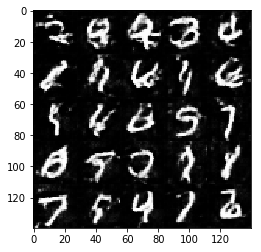

epoch 1 of 2 - generator loss: 0.830 discriminator loss: 1.057 
epoch 1 of 2 - generator loss: 0.237 discriminator loss: 2.218 
epoch 1 of 2 - generator loss: 0.320 discriminator loss: 1.760 
epoch 1 of 2 - generator loss: 0.554 discriminator loss: 1.407 
epoch 1 of 2 - generator loss: 1.123 discriminator loss: 0.935 
epoch 1 of 2 - generator loss: 1.152 discriminator loss: 0.951 
epoch 1 of 2 - generator loss: 0.504 discriminator loss: 1.565 
epoch 1 of 2 - generator loss: 0.617 discriminator loss: 1.285 
epoch 1 of 2 - generator loss: 0.596 discriminator loss: 1.345 
epoch 1 of 2 - generator loss: 0.400 discriminator loss: 1.569 


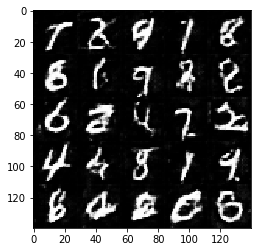

epoch 1 of 2 - generator loss: 0.651 discriminator loss: 1.241 
epoch 1 of 2 - generator loss: 0.468 discriminator loss: 1.525 
epoch 1 of 2 - generator loss: 0.521 discriminator loss: 1.398 
epoch 1 of 2 - generator loss: 0.469 discriminator loss: 1.434 
epoch 1 of 2 - generator loss: 0.975 discriminator loss: 0.941 
epoch 1 of 2 - generator loss: 1.343 discriminator loss: 0.882 
epoch 1 of 2 - generator loss: 0.295 discriminator loss: 2.016 
epoch 1 of 2 - generator loss: 1.238 discriminator loss: 0.824 
epoch 1 of 2 - generator loss: 0.739 discriminator loss: 1.146 
epoch 1 of 2 - generator loss: 0.580 discriminator loss: 1.308 


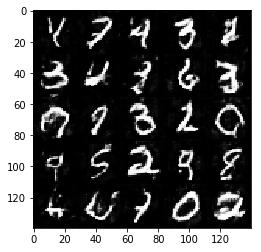

epoch 1 of 2 - generator loss: 1.043 discriminator loss: 1.092 
epoch 1 of 2 - generator loss: 0.598 discriminator loss: 1.318 
epoch 1 of 2 - generator loss: 0.830 discriminator loss: 1.006 
epoch 1 of 2 - generator loss: 0.827 discriminator loss: 1.263 
epoch 1 of 2 - generator loss: 1.607 discriminator loss: 0.989 
epoch 1 of 2 - generator loss: 1.573 discriminator loss: 0.949 
epoch 1 of 2 - generator loss: 0.401 discriminator loss: 1.642 
epoch 1 of 2 - generator loss: 1.215 discriminator loss: 0.955 
epoch 1 of 2 - generator loss: 1.020 discriminator loss: 0.887 
epoch 1 of 2 - generator loss: 0.604 discriminator loss: 1.267 


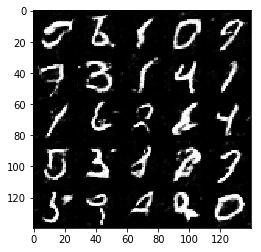

epoch 1 of 2 - generator loss: 0.705 discriminator loss: 1.209 
epoch 1 of 2 - generator loss: 0.493 discriminator loss: 1.466 
epoch 1 of 2 - generator loss: 1.142 discriminator loss: 1.196 
epoch 1 of 2 - generator loss: 0.835 discriminator loss: 1.017 
epoch 1 of 2 - generator loss: 0.924 discriminator loss: 1.036 
epoch 1 of 2 - generator loss: 1.121 discriminator loss: 0.942 
epoch 1 of 2 - generator loss: 0.986 discriminator loss: 0.974 
epoch 1 of 2 - generator loss: 1.308 discriminator loss: 0.874 
epoch 1 of 2 - generator loss: 0.633 discriminator loss: 1.265 
epoch 1 of 2 - generator loss: 0.636 discriminator loss: 1.263 


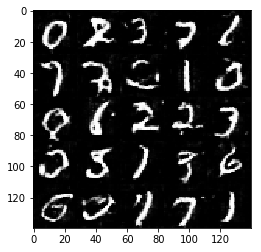

epoch 1 of 2 - generator loss: 1.295 discriminator loss: 0.911 
epoch 1 of 2 - generator loss: 0.292 discriminator loss: 2.005 
epoch 1 of 2 - generator loss: 0.589 discriminator loss: 1.292 
epoch 1 of 2 - generator loss: 1.057 discriminator loss: 1.056 
epoch 1 of 2 - generator loss: 0.519 discriminator loss: 1.432 
epoch 1 of 2 - generator loss: 0.352 discriminator loss: 1.760 
epoch 1 of 2 - generator loss: 0.674 discriminator loss: 1.254 
epoch 1 of 2 - generator loss: 1.636 discriminator loss: 1.061 
epoch 1 of 2 - generator loss: 0.800 discriminator loss: 1.086 
epoch 1 of 2 - generator loss: 0.456 discriminator loss: 1.547 


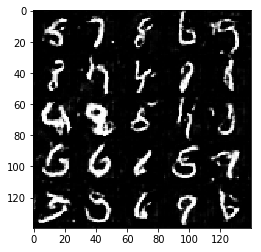

epoch 1 of 2 - generator loss: 0.699 discriminator loss: 1.149 
epoch 1 of 2 - generator loss: 0.711 discriminator loss: 1.162 
epoch 1 of 2 - generator loss: 1.768 discriminator loss: 1.112 
epoch 1 of 2 - generator loss: 0.353 discriminator loss: 1.706 
epoch 1 of 2 - generator loss: 0.748 discriminator loss: 1.155 
epoch 1 of 2 - generator loss: 1.003 discriminator loss: 1.057 
epoch 1 of 2 - generator loss: 0.593 discriminator loss: 1.309 
epoch 1 of 2 - generator loss: 0.713 discriminator loss: 1.188 
epoch 1 of 2 - generator loss: 0.741 discriminator loss: 1.219 
epoch 1 of 2 - generator loss: 0.522 discriminator loss: 1.426 


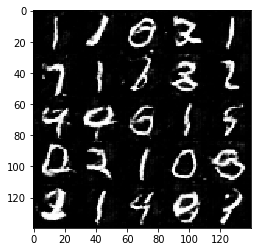

epoch 1 of 2 - generator loss: 0.374 discriminator loss: 1.625 
epoch 1 of 2 - generator loss: 1.095 discriminator loss: 0.922 
epoch 1 of 2 - generator loss: 0.666 discriminator loss: 1.373 
epoch 1 of 2 - generator loss: 0.978 discriminator loss: 0.959 
epoch 1 of 2 - generator loss: 0.524 discriminator loss: 1.543 
epoch 1 of 2 - generator loss: 0.586 discriminator loss: 1.314 
epoch 1 of 2 - generator loss: 1.070 discriminator loss: 0.970 
epoch 1 of 2 - generator loss: 0.922 discriminator loss: 1.022 
epoch 1 of 2 - generator loss: 1.162 discriminator loss: 0.927 
epoch 1 of 2 - generator loss: 0.955 discriminator loss: 1.019 


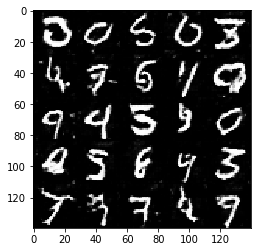

epoch 1 of 2 - generator loss: 0.671 discriminator loss: 1.232 
epoch 1 of 2 - generator loss: 1.001 discriminator loss: 1.098 
epoch 1 of 2 - generator loss: 1.333 discriminator loss: 0.980 
epoch 1 of 2 - generator loss: 1.202 discriminator loss: 1.019 
epoch 1 of 2 - generator loss: 1.296 discriminator loss: 0.883 
epoch 1 of 2 - generator loss: 0.672 discriminator loss: 1.257 
epoch 1 of 2 - generator loss: 0.687 discriminator loss: 1.276 
epoch 1 of 2 - generator loss: 1.615 discriminator loss: 0.700 
epoch 1 of 2 - generator loss: 0.734 discriminator loss: 1.326 
epoch 1 of 2 - generator loss: 1.781 discriminator loss: 0.651 


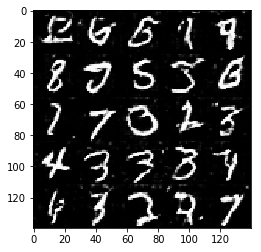

epoch 1 of 2 - generator loss: 1.026 discriminator loss: 0.933 
epoch 1 of 2 - generator loss: 1.371 discriminator loss: 0.775 
epoch 1 of 2 - generator loss: 0.810 discriminator loss: 1.110 
epoch 1 of 2 - generator loss: 1.181 discriminator loss: 0.999 
epoch 1 of 2 - generator loss: 0.786 discriminator loss: 1.076 
epoch 1 of 2 - generator loss: 0.964 discriminator loss: 1.068 
epoch 1 of 2 - generator loss: 0.822 discriminator loss: 1.026 
epoch 1 of 2 - generator loss: 0.963 discriminator loss: 1.022 
epoch 1 of 2 - generator loss: 0.864 discriminator loss: 1.036 
epoch 1 of 2 - generator loss: 1.338 discriminator loss: 0.778 


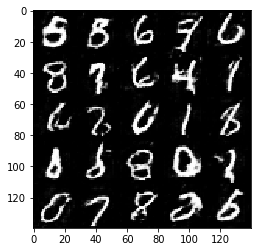

epoch 1 of 2 - generator loss: 0.830 discriminator loss: 1.126 
epoch 1 of 2 - generator loss: 1.268 discriminator loss: 0.837 
epoch 1 of 2 - generator loss: 0.427 discriminator loss: 1.493 
epoch 1 of 2 - generator loss: 1.129 discriminator loss: 1.015 
epoch 1 of 2 - generator loss: 1.610 discriminator loss: 1.216 
epoch 1 of 2 - generator loss: 0.286 discriminator loss: 1.851 
epoch 1 of 2 - generator loss: 1.171 discriminator loss: 0.880 
epoch 2 of 2 - generator loss: 0.863 discriminator loss: 0.988 
epoch 2 of 2 - generator loss: 1.066 discriminator loss: 0.988 
epoch 2 of 2 - generator loss: 0.948 discriminator loss: 0.933 


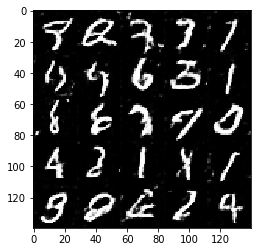

epoch 2 of 2 - generator loss: 1.009 discriminator loss: 1.017 
epoch 2 of 2 - generator loss: 0.880 discriminator loss: 1.094 
epoch 2 of 2 - generator loss: 0.833 discriminator loss: 1.154 
epoch 2 of 2 - generator loss: 0.782 discriminator loss: 1.177 
epoch 2 of 2 - generator loss: 1.012 discriminator loss: 1.056 
epoch 2 of 2 - generator loss: 0.591 discriminator loss: 1.405 
epoch 2 of 2 - generator loss: 0.512 discriminator loss: 1.419 
epoch 2 of 2 - generator loss: 0.504 discriminator loss: 1.422 
epoch 2 of 2 - generator loss: 0.717 discriminator loss: 1.134 
epoch 2 of 2 - generator loss: 0.902 discriminator loss: 1.067 


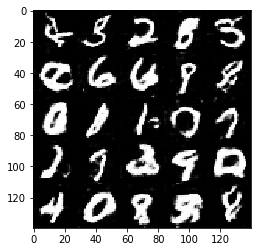

epoch 2 of 2 - generator loss: 0.667 discriminator loss: 1.228 
epoch 2 of 2 - generator loss: 0.985 discriminator loss: 0.987 
epoch 2 of 2 - generator loss: 0.520 discriminator loss: 1.319 
epoch 2 of 2 - generator loss: 1.668 discriminator loss: 0.701 
epoch 2 of 2 - generator loss: 0.942 discriminator loss: 1.047 
epoch 2 of 2 - generator loss: 0.933 discriminator loss: 0.953 
epoch 2 of 2 - generator loss: 1.195 discriminator loss: 0.911 
epoch 2 of 2 - generator loss: 1.096 discriminator loss: 1.148 
epoch 2 of 2 - generator loss: 0.557 discriminator loss: 1.508 
epoch 2 of 2 - generator loss: 1.713 discriminator loss: 1.136 


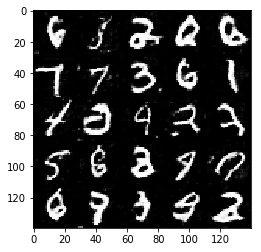

epoch 2 of 2 - generator loss: 0.299 discriminator loss: 1.889 
epoch 2 of 2 - generator loss: 1.053 discriminator loss: 1.123 
epoch 2 of 2 - generator loss: 1.239 discriminator loss: 0.832 
epoch 2 of 2 - generator loss: 0.983 discriminator loss: 1.020 
epoch 2 of 2 - generator loss: 0.563 discriminator loss: 1.380 
epoch 2 of 2 - generator loss: 0.900 discriminator loss: 0.958 
epoch 2 of 2 - generator loss: 0.840 discriminator loss: 1.067 
epoch 2 of 2 - generator loss: 1.081 discriminator loss: 1.081 
epoch 2 of 2 - generator loss: 1.015 discriminator loss: 1.007 
epoch 2 of 2 - generator loss: 0.918 discriminator loss: 1.093 


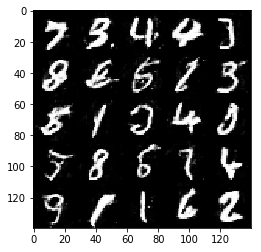

epoch 2 of 2 - generator loss: 1.336 discriminator loss: 0.957 
epoch 2 of 2 - generator loss: 1.356 discriminator loss: 0.803 
epoch 2 of 2 - generator loss: 1.017 discriminator loss: 1.064 
epoch 2 of 2 - generator loss: 1.688 discriminator loss: 0.757 
epoch 2 of 2 - generator loss: 0.990 discriminator loss: 0.968 
epoch 2 of 2 - generator loss: 1.382 discriminator loss: 0.829 
epoch 2 of 2 - generator loss: 2.492 discriminator loss: 1.277 
epoch 2 of 2 - generator loss: 0.657 discriminator loss: 1.224 
epoch 2 of 2 - generator loss: 0.660 discriminator loss: 1.272 
epoch 2 of 2 - generator loss: 0.790 discriminator loss: 1.080 


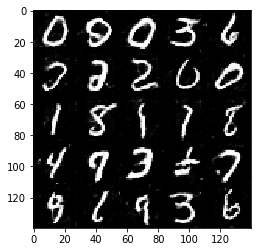

epoch 2 of 2 - generator loss: 1.342 discriminator loss: 0.866 
epoch 2 of 2 - generator loss: 0.547 discriminator loss: 1.432 
epoch 2 of 2 - generator loss: 0.656 discriminator loss: 1.409 
epoch 2 of 2 - generator loss: 0.961 discriminator loss: 1.099 
epoch 2 of 2 - generator loss: 0.621 discriminator loss: 1.340 
epoch 2 of 2 - generator loss: 0.566 discriminator loss: 1.569 
epoch 2 of 2 - generator loss: 1.038 discriminator loss: 1.015 
epoch 2 of 2 - generator loss: 0.884 discriminator loss: 1.049 
epoch 2 of 2 - generator loss: 1.396 discriminator loss: 0.818 
epoch 2 of 2 - generator loss: 0.669 discriminator loss: 1.258 


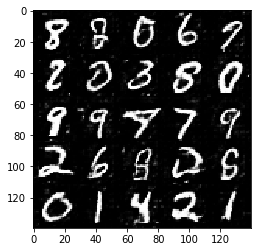

epoch 2 of 2 - generator loss: 0.374 discriminator loss: 1.687 
epoch 2 of 2 - generator loss: 1.026 discriminator loss: 0.960 
epoch 2 of 2 - generator loss: 0.913 discriminator loss: 1.020 
epoch 2 of 2 - generator loss: 1.304 discriminator loss: 1.056 
epoch 2 of 2 - generator loss: 0.658 discriminator loss: 1.370 
epoch 2 of 2 - generator loss: 1.272 discriminator loss: 0.916 
epoch 2 of 2 - generator loss: 0.582 discriminator loss: 1.337 
epoch 2 of 2 - generator loss: 0.755 discriminator loss: 1.159 
epoch 2 of 2 - generator loss: 1.349 discriminator loss: 0.754 
epoch 2 of 2 - generator loss: 0.427 discriminator loss: 1.630 


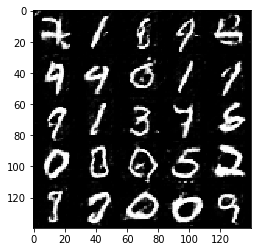

epoch 2 of 2 - generator loss: 0.333 discriminator loss: 1.902 
epoch 2 of 2 - generator loss: 1.130 discriminator loss: 0.943 
epoch 2 of 2 - generator loss: 0.339 discriminator loss: 1.944 
epoch 2 of 2 - generator loss: 0.517 discriminator loss: 1.472 
epoch 2 of 2 - generator loss: 0.320 discriminator loss: 1.880 
epoch 2 of 2 - generator loss: 0.951 discriminator loss: 1.064 
epoch 2 of 2 - generator loss: 0.708 discriminator loss: 1.108 
epoch 2 of 2 - generator loss: 0.765 discriminator loss: 1.193 
epoch 2 of 2 - generator loss: 1.156 discriminator loss: 1.019 
epoch 2 of 2 - generator loss: 1.458 discriminator loss: 0.990 


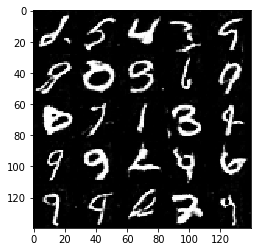

epoch 2 of 2 - generator loss: 0.508 discriminator loss: 1.493 
epoch 2 of 2 - generator loss: 0.798 discriminator loss: 1.252 
epoch 2 of 2 - generator loss: 0.647 discriminator loss: 1.199 
epoch 2 of 2 - generator loss: 0.698 discriminator loss: 1.250 
epoch 2 of 2 - generator loss: 0.717 discriminator loss: 1.187 
epoch 2 of 2 - generator loss: 2.178 discriminator loss: 0.759 
epoch 2 of 2 - generator loss: 1.271 discriminator loss: 0.819 
epoch 2 of 2 - generator loss: 1.097 discriminator loss: 0.898 
epoch 2 of 2 - generator loss: 0.653 discriminator loss: 1.334 
epoch 2 of 2 - generator loss: 0.634 discriminator loss: 1.327 


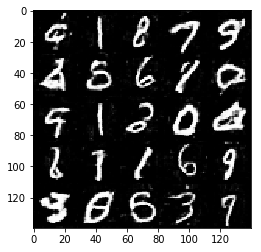

epoch 2 of 2 - generator loss: 0.765 discriminator loss: 1.103 
epoch 2 of 2 - generator loss: 0.608 discriminator loss: 1.301 
epoch 2 of 2 - generator loss: 0.454 discriminator loss: 1.537 
epoch 2 of 2 - generator loss: 1.885 discriminator loss: 1.065 
epoch 2 of 2 - generator loss: 1.199 discriminator loss: 0.955 
epoch 2 of 2 - generator loss: 1.257 discriminator loss: 0.850 
epoch 2 of 2 - generator loss: 1.790 discriminator loss: 1.286 
epoch 2 of 2 - generator loss: 1.271 discriminator loss: 0.831 
epoch 2 of 2 - generator loss: 0.780 discriminator loss: 1.110 
epoch 2 of 2 - generator loss: 0.941 discriminator loss: 1.000 


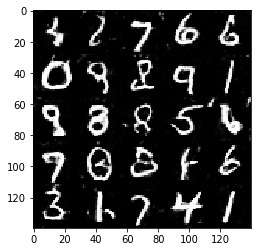

epoch 2 of 2 - generator loss: 0.646 discriminator loss: 1.254 
epoch 2 of 2 - generator loss: 1.337 discriminator loss: 0.859 
epoch 2 of 2 - generator loss: 1.218 discriminator loss: 0.871 
epoch 2 of 2 - generator loss: 0.966 discriminator loss: 0.958 
epoch 2 of 2 - generator loss: 1.165 discriminator loss: 1.020 
epoch 2 of 2 - generator loss: 0.826 discriminator loss: 1.162 
epoch 2 of 2 - generator loss: 0.432 discriminator loss: 1.677 
epoch 2 of 2 - generator loss: 0.744 discriminator loss: 1.174 
epoch 2 of 2 - generator loss: 1.326 discriminator loss: 0.783 
epoch 2 of 2 - generator loss: 1.342 discriminator loss: 0.961 


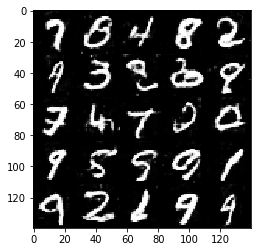

epoch 2 of 2 - generator loss: 1.536 discriminator loss: 0.736 
epoch 2 of 2 - generator loss: 0.840 discriminator loss: 1.122 
epoch 2 of 2 - generator loss: 0.823 discriminator loss: 1.094 
epoch 2 of 2 - generator loss: 0.861 discriminator loss: 1.083 
epoch 2 of 2 - generator loss: 0.831 discriminator loss: 1.087 
epoch 2 of 2 - generator loss: 0.651 discriminator loss: 1.264 
epoch 2 of 2 - generator loss: 0.740 discriminator loss: 1.194 
epoch 2 of 2 - generator loss: 0.937 discriminator loss: 1.070 
epoch 2 of 2 - generator loss: 1.378 discriminator loss: 0.922 
epoch 2 of 2 - generator loss: 1.114 discriminator loss: 0.945 


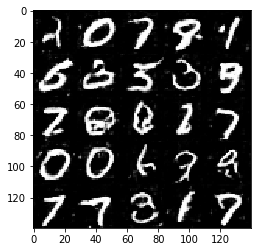

epoch 2 of 2 - generator loss: 0.537 discriminator loss: 1.438 
epoch 2 of 2 - generator loss: 1.011 discriminator loss: 0.957 
epoch 2 of 2 - generator loss: 1.797 discriminator loss: 1.192 
epoch 2 of 2 - generator loss: 0.660 discriminator loss: 1.220 
epoch 2 of 2 - generator loss: 1.129 discriminator loss: 0.950 
epoch 2 of 2 - generator loss: 0.686 discriminator loss: 1.199 
epoch 2 of 2 - generator loss: 0.511 discriminator loss: 1.402 
epoch 2 of 2 - generator loss: 1.396 discriminator loss: 0.774 
epoch 2 of 2 - generator loss: 0.925 discriminator loss: 1.254 
epoch 2 of 2 - generator loss: 0.639 discriminator loss: 1.366 


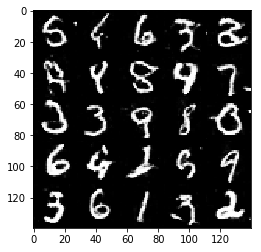

epoch 2 of 2 - generator loss: 0.901 discriminator loss: 1.042 
epoch 2 of 2 - generator loss: 1.656 discriminator loss: 0.806 
epoch 2 of 2 - generator loss: 0.593 discriminator loss: 1.445 
epoch 2 of 2 - generator loss: 1.157 discriminator loss: 0.984 
epoch 2 of 2 - generator loss: 1.254 discriminator loss: 0.812 
epoch 2 of 2 - generator loss: 1.473 discriminator loss: 1.156 
epoch 2 of 2 - generator loss: 0.391 discriminator loss: 1.588 
epoch 2 of 2 - generator loss: 0.646 discriminator loss: 1.297 
epoch 2 of 2 - generator loss: 1.025 discriminator loss: 1.165 
epoch 2 of 2 - generator loss: 1.107 discriminator loss: 1.079 


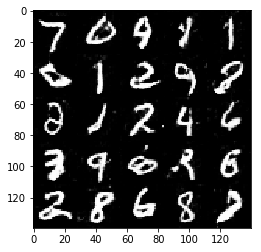

epoch 2 of 2 - generator loss: 0.413 discriminator loss: 1.703 
epoch 2 of 2 - generator loss: 0.764 discriminator loss: 1.213 
epoch 2 of 2 - generator loss: 0.663 discriminator loss: 1.262 
epoch 2 of 2 - generator loss: 1.373 discriminator loss: 0.925 
epoch 2 of 2 - generator loss: 0.848 discriminator loss: 1.049 
epoch 2 of 2 - generator loss: 1.328 discriminator loss: 0.799 
epoch 2 of 2 - generator loss: 0.743 discriminator loss: 1.176 
epoch 2 of 2 - generator loss: 0.532 discriminator loss: 1.430 
epoch 2 of 2 - generator loss: 0.697 discriminator loss: 1.121 
epoch 2 of 2 - generator loss: 1.825 discriminator loss: 0.959 


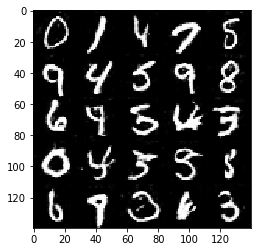

epoch 2 of 2 - generator loss: 1.091 discriminator loss: 0.942 
epoch 2 of 2 - generator loss: 0.771 discriminator loss: 1.114 
epoch 2 of 2 - generator loss: 1.371 discriminator loss: 0.796 
epoch 2 of 2 - generator loss: 1.278 discriminator loss: 0.957 
epoch 2 of 2 - generator loss: 1.320 discriminator loss: 0.949 
epoch 2 of 2 - generator loss: 1.645 discriminator loss: 0.763 
epoch 2 of 2 - generator loss: 0.589 discriminator loss: 1.365 
epoch 2 of 2 - generator loss: 1.031 discriminator loss: 1.107 
epoch 2 of 2 - generator loss: 1.414 discriminator loss: 0.922 
epoch 2 of 2 - generator loss: 0.565 discriminator loss: 1.404 


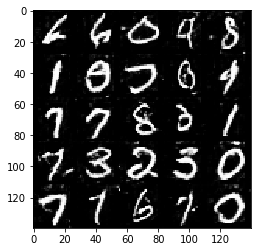

epoch 2 of 2 - generator loss: 0.330 discriminator loss: 1.834 
epoch 2 of 2 - generator loss: 1.038 discriminator loss: 1.021 
epoch 2 of 2 - generator loss: 0.659 discriminator loss: 1.319 
epoch 2 of 2 - generator loss: 0.821 discriminator loss: 1.030 
epoch 2 of 2 - generator loss: 0.443 discriminator loss: 1.552 
epoch 2 of 2 - generator loss: 0.668 discriminator loss: 1.387 
epoch 2 of 2 - generator loss: 0.923 discriminator loss: 0.979 
epoch 2 of 2 - generator loss: 1.388 discriminator loss: 0.830 
epoch 2 of 2 - generator loss: 1.123 discriminator loss: 0.950 
epoch 2 of 2 - generator loss: 1.134 discriminator loss: 0.900 


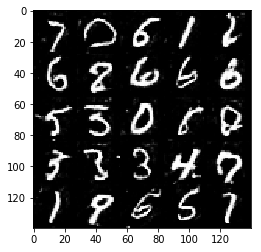

epoch 2 of 2 - generator loss: 0.301 discriminator loss: 1.838 
epoch 2 of 2 - generator loss: 2.129 discriminator loss: 0.960 
epoch 2 of 2 - generator loss: 0.665 discriminator loss: 1.180 
epoch 2 of 2 - generator loss: 0.986 discriminator loss: 0.919 
epoch 2 of 2 - generator loss: 0.729 discriminator loss: 1.258 
epoch 2 of 2 - generator loss: 0.417 discriminator loss: 1.686 
epoch 2 of 2 - generator loss: 0.529 discriminator loss: 1.482 
epoch 2 of 2 - generator loss: 1.036 discriminator loss: 0.923 
epoch 2 of 2 - generator loss: 0.193 discriminator loss: 2.809 
epoch 2 of 2 - generator loss: 1.293 discriminator loss: 1.497 


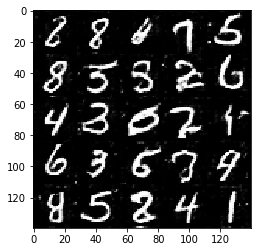

epoch 2 of 2 - generator loss: 1.548 discriminator loss: 0.756 
epoch 2 of 2 - generator loss: 0.682 discriminator loss: 1.221 
epoch 2 of 2 - generator loss: 0.593 discriminator loss: 1.362 
epoch 2 of 2 - generator loss: 0.387 discriminator loss: 1.559 
epoch 2 of 2 - generator loss: 0.963 discriminator loss: 0.998 
epoch 2 of 2 - generator loss: 0.389 discriminator loss: 1.784 
epoch 2 of 2 - generator loss: 0.650 discriminator loss: 1.280 
epoch 2 of 2 - generator loss: 0.476 discriminator loss: 1.720 
epoch 2 of 2 - generator loss: 0.236 discriminator loss: 2.177 
epoch 2 of 2 - generator loss: 0.822 discriminator loss: 1.065 


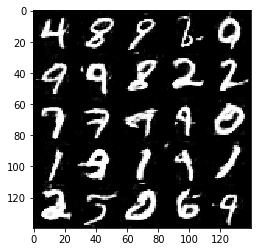

epoch 2 of 2 - generator loss: 1.300 discriminator loss: 0.820 
epoch 2 of 2 - generator loss: 1.115 discriminator loss: 0.904 
epoch 2 of 2 - generator loss: 0.533 discriminator loss: 1.596 
epoch 2 of 2 - generator loss: 1.075 discriminator loss: 0.958 
epoch 2 of 2 - generator loss: 0.722 discriminator loss: 1.125 
Final output:


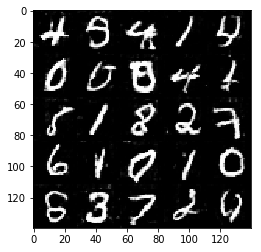

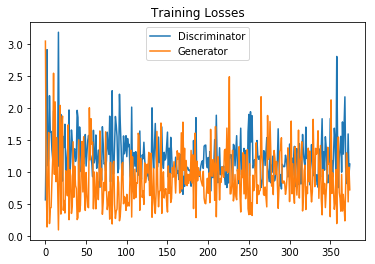

In [151]:
batch_size = 32
z_dim = 100
learning_rate = 0.0008
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

epoch 1 of 1 - generator loss: 3.684 discriminator loss: 0.483 
epoch 1 of 1 - generator loss: 0.408 discriminator loss: 1.773 
epoch 1 of 1 - generator loss: 0.971 discriminator loss: 1.572 
epoch 1 of 1 - generator loss: 0.349 discriminator loss: 1.911 
epoch 1 of 1 - generator loss: 1.089 discriminator loss: 1.426 
epoch 1 of 1 - generator loss: 0.500 discriminator loss: 1.650 
epoch 1 of 1 - generator loss: 0.904 discriminator loss: 1.167 
epoch 1 of 1 - generator loss: 0.105 discriminator loss: 2.843 
epoch 1 of 1 - generator loss: 0.760 discriminator loss: 1.391 
epoch 1 of 1 - generator loss: 0.739 discriminator loss: 1.809 


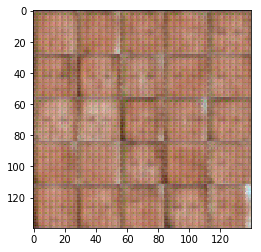

epoch 1 of 1 - generator loss: 0.601 discriminator loss: 1.592 
epoch 1 of 1 - generator loss: 0.763 discriminator loss: 1.295 
epoch 1 of 1 - generator loss: 0.450 discriminator loss: 1.674 
epoch 1 of 1 - generator loss: 0.566 discriminator loss: 1.404 
epoch 1 of 1 - generator loss: 0.831 discriminator loss: 1.411 
epoch 1 of 1 - generator loss: 0.585 discriminator loss: 1.489 
epoch 1 of 1 - generator loss: 0.630 discriminator loss: 1.733 
epoch 1 of 1 - generator loss: 0.637 discriminator loss: 1.324 
epoch 1 of 1 - generator loss: 0.764 discriminator loss: 1.342 
epoch 1 of 1 - generator loss: 0.632 discriminator loss: 1.486 


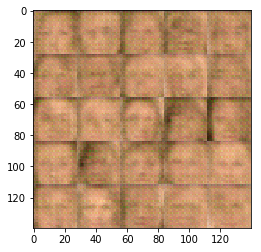

epoch 1 of 1 - generator loss: 0.681 discriminator loss: 1.394 
epoch 1 of 1 - generator loss: 0.935 discriminator loss: 1.724 
epoch 1 of 1 - generator loss: 0.738 discriminator loss: 1.452 
epoch 1 of 1 - generator loss: 1.560 discriminator loss: 1.697 
epoch 1 of 1 - generator loss: 0.497 discriminator loss: 1.559 
epoch 1 of 1 - generator loss: 0.889 discriminator loss: 1.079 
epoch 1 of 1 - generator loss: 0.595 discriminator loss: 1.461 
epoch 1 of 1 - generator loss: 0.601 discriminator loss: 1.375 
epoch 1 of 1 - generator loss: 0.783 discriminator loss: 1.353 
epoch 1 of 1 - generator loss: 0.561 discriminator loss: 1.474 


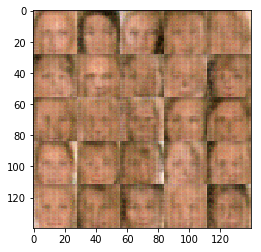

epoch 1 of 1 - generator loss: 0.302 discriminator loss: 1.877 
epoch 1 of 1 - generator loss: 0.739 discriminator loss: 1.318 
epoch 1 of 1 - generator loss: 0.675 discriminator loss: 1.099 
epoch 1 of 1 - generator loss: 0.735 discriminator loss: 1.676 
epoch 1 of 1 - generator loss: 0.860 discriminator loss: 1.317 
epoch 1 of 1 - generator loss: 0.802 discriminator loss: 1.561 
epoch 1 of 1 - generator loss: 0.627 discriminator loss: 1.315 
epoch 1 of 1 - generator loss: 0.466 discriminator loss: 1.383 
epoch 1 of 1 - generator loss: 0.746 discriminator loss: 1.232 
epoch 1 of 1 - generator loss: 1.052 discriminator loss: 1.446 


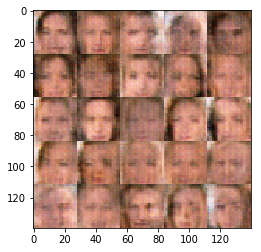

epoch 1 of 1 - generator loss: 0.494 discriminator loss: 1.543 
epoch 1 of 1 - generator loss: 0.733 discriminator loss: 1.483 
epoch 1 of 1 - generator loss: 1.766 discriminator loss: 1.773 
epoch 1 of 1 - generator loss: 1.018 discriminator loss: 1.297 
epoch 1 of 1 - generator loss: 0.804 discriminator loss: 1.406 
epoch 1 of 1 - generator loss: 0.820 discriminator loss: 1.328 
epoch 1 of 1 - generator loss: 0.918 discriminator loss: 1.419 
epoch 1 of 1 - generator loss: 1.000 discriminator loss: 1.510 
epoch 1 of 1 - generator loss: 0.440 discriminator loss: 1.495 
epoch 1 of 1 - generator loss: 0.651 discriminator loss: 1.522 


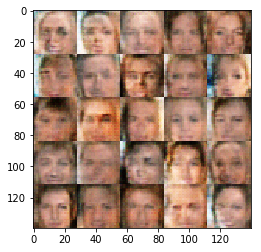

epoch 1 of 1 - generator loss: 0.621 discriminator loss: 1.511 
epoch 1 of 1 - generator loss: 0.675 discriminator loss: 1.354 
epoch 1 of 1 - generator loss: 0.458 discriminator loss: 1.514 
epoch 1 of 1 - generator loss: 0.930 discriminator loss: 1.271 
epoch 1 of 1 - generator loss: 0.850 discriminator loss: 1.450 
epoch 1 of 1 - generator loss: 0.409 discriminator loss: 1.532 
epoch 1 of 1 - generator loss: 1.799 discriminator loss: 1.578 
epoch 1 of 1 - generator loss: 1.043 discriminator loss: 1.479 
epoch 1 of 1 - generator loss: 0.817 discriminator loss: 1.559 
epoch 1 of 1 - generator loss: 0.537 discriminator loss: 1.483 


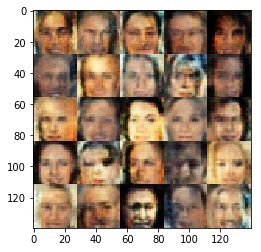

epoch 1 of 1 - generator loss: 0.743 discriminator loss: 1.336 
epoch 1 of 1 - generator loss: 0.978 discriminator loss: 1.334 
epoch 1 of 1 - generator loss: 0.730 discriminator loss: 1.426 
epoch 1 of 1 - generator loss: 0.645 discriminator loss: 1.360 
epoch 1 of 1 - generator loss: 0.933 discriminator loss: 1.295 
epoch 1 of 1 - generator loss: 0.692 discriminator loss: 1.389 
epoch 1 of 1 - generator loss: 0.808 discriminator loss: 1.104 
epoch 1 of 1 - generator loss: 1.251 discriminator loss: 1.609 
epoch 1 of 1 - generator loss: 0.620 discriminator loss: 1.430 
epoch 1 of 1 - generator loss: 0.546 discriminator loss: 1.386 


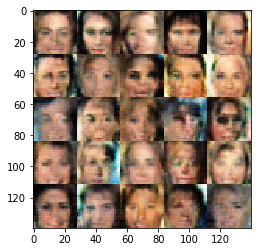

epoch 1 of 1 - generator loss: 0.583 discriminator loss: 1.415 
epoch 1 of 1 - generator loss: 1.048 discriminator loss: 1.256 
epoch 1 of 1 - generator loss: 0.357 discriminator loss: 1.676 
epoch 1 of 1 - generator loss: 1.122 discriminator loss: 1.258 
epoch 1 of 1 - generator loss: 0.891 discriminator loss: 1.217 
epoch 1 of 1 - generator loss: 0.766 discriminator loss: 1.245 
epoch 1 of 1 - generator loss: 0.458 discriminator loss: 1.755 
epoch 1 of 1 - generator loss: 0.955 discriminator loss: 1.314 
epoch 1 of 1 - generator loss: 0.699 discriminator loss: 1.466 
epoch 1 of 1 - generator loss: 0.789 discriminator loss: 1.337 


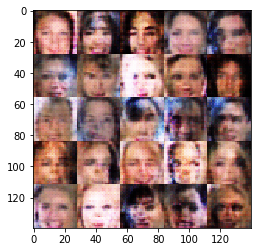

epoch 1 of 1 - generator loss: 1.083 discriminator loss: 1.288 
epoch 1 of 1 - generator loss: 0.304 discriminator loss: 1.850 
epoch 1 of 1 - generator loss: 0.899 discriminator loss: 1.170 
epoch 1 of 1 - generator loss: 0.903 discriminator loss: 1.349 
epoch 1 of 1 - generator loss: 0.988 discriminator loss: 1.241 
epoch 1 of 1 - generator loss: 0.788 discriminator loss: 1.189 
epoch 1 of 1 - generator loss: 1.103 discriminator loss: 1.264 
epoch 1 of 1 - generator loss: 0.660 discriminator loss: 1.177 
epoch 1 of 1 - generator loss: 0.750 discriminator loss: 1.537 
epoch 1 of 1 - generator loss: 1.482 discriminator loss: 1.619 


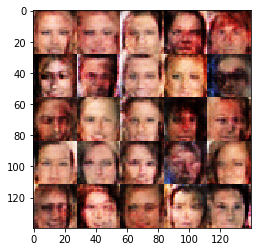

epoch 1 of 1 - generator loss: 0.684 discriminator loss: 1.215 
epoch 1 of 1 - generator loss: 0.563 discriminator loss: 1.353 
epoch 1 of 1 - generator loss: 0.738 discriminator loss: 1.290 
epoch 1 of 1 - generator loss: 0.794 discriminator loss: 1.366 
epoch 1 of 1 - generator loss: 0.848 discriminator loss: 1.220 
epoch 1 of 1 - generator loss: 0.587 discriminator loss: 1.494 
epoch 1 of 1 - generator loss: 0.848 discriminator loss: 1.066 
epoch 1 of 1 - generator loss: 0.724 discriminator loss: 1.271 
epoch 1 of 1 - generator loss: 0.563 discriminator loss: 1.349 
epoch 1 of 1 - generator loss: 0.808 discriminator loss: 1.490 


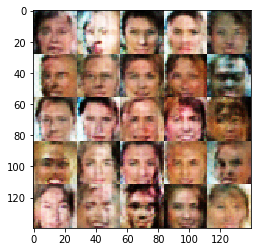

epoch 1 of 1 - generator loss: 0.878 discriminator loss: 1.209 
epoch 1 of 1 - generator loss: 0.626 discriminator loss: 1.390 
epoch 1 of 1 - generator loss: 0.886 discriminator loss: 1.312 
epoch 1 of 1 - generator loss: 0.846 discriminator loss: 1.286 
epoch 1 of 1 - generator loss: 1.135 discriminator loss: 1.302 
epoch 1 of 1 - generator loss: 0.629 discriminator loss: 1.271 
epoch 1 of 1 - generator loss: 1.032 discriminator loss: 1.206 
epoch 1 of 1 - generator loss: 0.464 discriminator loss: 1.453 
epoch 1 of 1 - generator loss: 0.665 discriminator loss: 1.407 
epoch 1 of 1 - generator loss: 0.778 discriminator loss: 1.375 


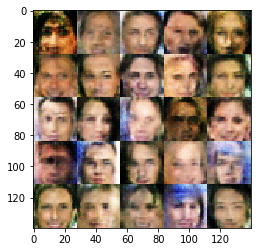

epoch 1 of 1 - generator loss: 0.726 discriminator loss: 1.348 
epoch 1 of 1 - generator loss: 0.828 discriminator loss: 1.335 
epoch 1 of 1 - generator loss: 0.730 discriminator loss: 1.379 
epoch 1 of 1 - generator loss: 0.799 discriminator loss: 1.301 
epoch 1 of 1 - generator loss: 0.568 discriminator loss: 1.671 
epoch 1 of 1 - generator loss: 0.597 discriminator loss: 1.495 
epoch 1 of 1 - generator loss: 0.872 discriminator loss: 1.067 
epoch 1 of 1 - generator loss: 0.751 discriminator loss: 1.359 
epoch 1 of 1 - generator loss: 0.707 discriminator loss: 1.291 
epoch 1 of 1 - generator loss: 0.706 discriminator loss: 1.368 


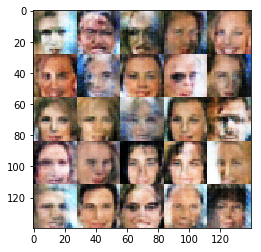

epoch 1 of 1 - generator loss: 0.696 discriminator loss: 1.428 
epoch 1 of 1 - generator loss: 0.745 discriminator loss: 1.448 
epoch 1 of 1 - generator loss: 0.670 discriminator loss: 1.519 
epoch 1 of 1 - generator loss: 0.918 discriminator loss: 1.567 
epoch 1 of 1 - generator loss: 0.684 discriminator loss: 1.181 
epoch 1 of 1 - generator loss: 0.733 discriminator loss: 1.403 
epoch 1 of 1 - generator loss: 0.869 discriminator loss: 1.290 
epoch 1 of 1 - generator loss: 0.733 discriminator loss: 1.404 
epoch 1 of 1 - generator loss: 0.809 discriminator loss: 1.259 
epoch 1 of 1 - generator loss: 0.833 discriminator loss: 1.391 


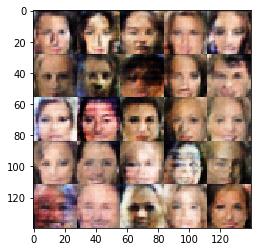

epoch 1 of 1 - generator loss: 0.714 discriminator loss: 1.536 
epoch 1 of 1 - generator loss: 0.916 discriminator loss: 1.417 
epoch 1 of 1 - generator loss: 0.950 discriminator loss: 1.375 
epoch 1 of 1 - generator loss: 0.980 discriminator loss: 1.519 
epoch 1 of 1 - generator loss: 0.971 discriminator loss: 1.458 
epoch 1 of 1 - generator loss: 1.142 discriminator loss: 1.423 
epoch 1 of 1 - generator loss: 0.761 discriminator loss: 1.449 
epoch 1 of 1 - generator loss: 0.900 discriminator loss: 1.421 
epoch 1 of 1 - generator loss: 0.626 discriminator loss: 1.445 
epoch 1 of 1 - generator loss: 0.792 discriminator loss: 1.143 


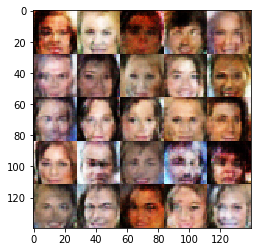

epoch 1 of 1 - generator loss: 0.634 discriminator loss: 1.435 
epoch 1 of 1 - generator loss: 0.490 discriminator loss: 1.438 
epoch 1 of 1 - generator loss: 0.800 discriminator loss: 1.400 
epoch 1 of 1 - generator loss: 0.836 discriminator loss: 1.232 
epoch 1 of 1 - generator loss: 0.569 discriminator loss: 1.430 
epoch 1 of 1 - generator loss: 0.732 discriminator loss: 1.351 
epoch 1 of 1 - generator loss: 0.530 discriminator loss: 1.418 
epoch 1 of 1 - generator loss: 0.781 discriminator loss: 1.235 
epoch 1 of 1 - generator loss: 0.413 discriminator loss: 1.601 
epoch 1 of 1 - generator loss: 1.044 discriminator loss: 1.289 


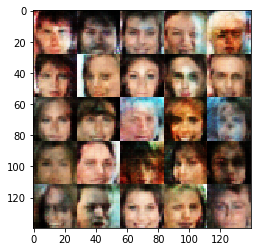

epoch 1 of 1 - generator loss: 0.656 discriminator loss: 1.640 
epoch 1 of 1 - generator loss: 0.737 discriminator loss: 1.530 
epoch 1 of 1 - generator loss: 0.424 discriminator loss: 1.591 
epoch 1 of 1 - generator loss: 0.555 discriminator loss: 1.498 
epoch 1 of 1 - generator loss: 0.755 discriminator loss: 1.445 
epoch 1 of 1 - generator loss: 0.675 discriminator loss: 1.570 
epoch 1 of 1 - generator loss: 0.507 discriminator loss: 1.435 
epoch 1 of 1 - generator loss: 0.907 discriminator loss: 1.034 
epoch 1 of 1 - generator loss: 0.500 discriminator loss: 1.429 
epoch 1 of 1 - generator loss: 0.473 discriminator loss: 1.552 


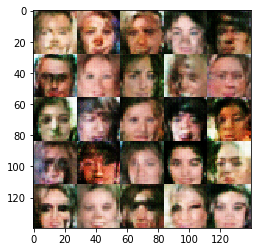

epoch 1 of 1 - generator loss: 0.715 discriminator loss: 1.422 
epoch 1 of 1 - generator loss: 0.653 discriminator loss: 1.354 
epoch 1 of 1 - generator loss: 0.386 discriminator loss: 1.579 
epoch 1 of 1 - generator loss: 0.510 discriminator loss: 1.429 
epoch 1 of 1 - generator loss: 0.804 discriminator loss: 1.236 
epoch 1 of 1 - generator loss: 0.505 discriminator loss: 1.398 
epoch 1 of 1 - generator loss: 0.499 discriminator loss: 1.413 
epoch 1 of 1 - generator loss: 0.858 discriminator loss: 1.399 
epoch 1 of 1 - generator loss: 0.717 discriminator loss: 1.426 
epoch 1 of 1 - generator loss: 0.574 discriminator loss: 1.431 


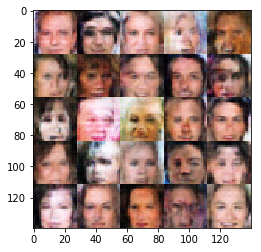

epoch 1 of 1 - generator loss: 0.594 discriminator loss: 1.461 
epoch 1 of 1 - generator loss: 0.584 discriminator loss: 1.462 
epoch 1 of 1 - generator loss: 0.864 discriminator loss: 1.311 
epoch 1 of 1 - generator loss: 0.653 discriminator loss: 1.184 
epoch 1 of 1 - generator loss: 0.823 discriminator loss: 1.303 
epoch 1 of 1 - generator loss: 0.547 discriminator loss: 1.521 
epoch 1 of 1 - generator loss: 0.448 discriminator loss: 1.520 
epoch 1 of 1 - generator loss: 0.439 discriminator loss: 1.568 
epoch 1 of 1 - generator loss: 0.410 discriminator loss: 1.660 
epoch 1 of 1 - generator loss: 0.772 discriminator loss: 1.216 


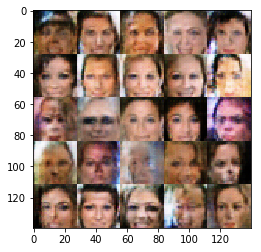

epoch 1 of 1 - generator loss: 0.651 discriminator loss: 1.319 
epoch 1 of 1 - generator loss: 0.831 discriminator loss: 1.439 
epoch 1 of 1 - generator loss: 0.617 discriminator loss: 1.486 
epoch 1 of 1 - generator loss: 0.625 discriminator loss: 1.335 
epoch 1 of 1 - generator loss: 0.684 discriminator loss: 1.570 
epoch 1 of 1 - generator loss: 0.902 discriminator loss: 1.139 
epoch 1 of 1 - generator loss: 0.435 discriminator loss: 1.523 
epoch 1 of 1 - generator loss: 0.927 discriminator loss: 1.283 
epoch 1 of 1 - generator loss: 0.558 discriminator loss: 1.279 
epoch 1 of 1 - generator loss: 0.687 discriminator loss: 1.406 


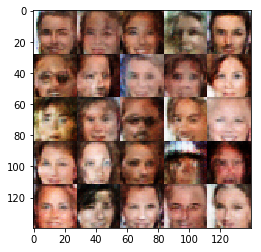

epoch 1 of 1 - generator loss: 0.683 discriminator loss: 1.261 
epoch 1 of 1 - generator loss: 0.403 discriminator loss: 1.689 
epoch 1 of 1 - generator loss: 0.811 discriminator loss: 1.239 
epoch 1 of 1 - generator loss: 0.588 discriminator loss: 1.501 
epoch 1 of 1 - generator loss: 0.675 discriminator loss: 1.287 
epoch 1 of 1 - generator loss: 0.526 discriminator loss: 1.454 
epoch 1 of 1 - generator loss: 0.899 discriminator loss: 1.231 
epoch 1 of 1 - generator loss: 0.654 discriminator loss: 1.548 
epoch 1 of 1 - generator loss: 0.437 discriminator loss: 1.548 
epoch 1 of 1 - generator loss: 0.891 discriminator loss: 1.462 


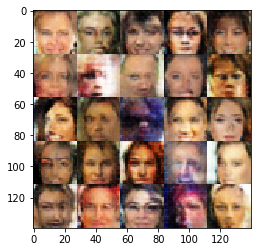

epoch 1 of 1 - generator loss: 0.587 discriminator loss: 1.503 
epoch 1 of 1 - generator loss: 0.532 discriminator loss: 1.401 
epoch 1 of 1 - generator loss: 0.417 discriminator loss: 1.596 
epoch 1 of 1 - generator loss: 0.797 discriminator loss: 1.354 
epoch 1 of 1 - generator loss: 0.567 discriminator loss: 1.455 
epoch 1 of 1 - generator loss: 0.628 discriminator loss: 1.372 
epoch 1 of 1 - generator loss: 1.394 discriminator loss: 1.430 
epoch 1 of 1 - generator loss: 0.527 discriminator loss: 1.374 
epoch 1 of 1 - generator loss: 0.456 discriminator loss: 1.497 
epoch 1 of 1 - generator loss: 0.387 discriminator loss: 1.682 


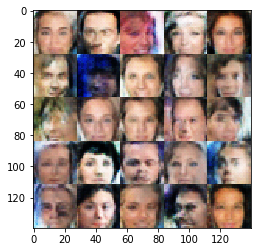

epoch 1 of 1 - generator loss: 0.831 discriminator loss: 1.352 
epoch 1 of 1 - generator loss: 0.562 discriminator loss: 1.490 
epoch 1 of 1 - generator loss: 0.965 discriminator loss: 1.278 
epoch 1 of 1 - generator loss: 0.725 discriminator loss: 1.461 
epoch 1 of 1 - generator loss: 0.677 discriminator loss: 1.490 
epoch 1 of 1 - generator loss: 0.796 discriminator loss: 1.266 
epoch 1 of 1 - generator loss: 0.462 discriminator loss: 1.508 
epoch 1 of 1 - generator loss: 0.379 discriminator loss: 1.623 
epoch 1 of 1 - generator loss: 0.431 discriminator loss: 1.678 
epoch 1 of 1 - generator loss: 0.651 discriminator loss: 1.218 


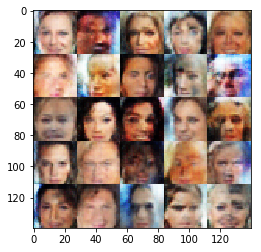

epoch 1 of 1 - generator loss: 0.839 discriminator loss: 1.330 
epoch 1 of 1 - generator loss: 0.839 discriminator loss: 1.381 
epoch 1 of 1 - generator loss: 0.490 discriminator loss: 1.447 
epoch 1 of 1 - generator loss: 0.716 discriminator loss: 1.501 
epoch 1 of 1 - generator loss: 0.376 discriminator loss: 1.608 
epoch 1 of 1 - generator loss: 0.528 discriminator loss: 1.545 
epoch 1 of 1 - generator loss: 0.933 discriminator loss: 1.421 
epoch 1 of 1 - generator loss: 0.526 discriminator loss: 1.359 
epoch 1 of 1 - generator loss: 0.598 discriminator loss: 1.362 
epoch 1 of 1 - generator loss: 1.065 discriminator loss: 1.519 


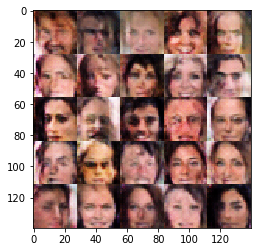

epoch 1 of 1 - generator loss: 0.861 discriminator loss: 1.328 
epoch 1 of 1 - generator loss: 0.782 discriminator loss: 1.500 
epoch 1 of 1 - generator loss: 0.642 discriminator loss: 1.349 
epoch 1 of 1 - generator loss: 0.775 discriminator loss: 1.277 
epoch 1 of 1 - generator loss: 0.353 discriminator loss: 1.695 
epoch 1 of 1 - generator loss: 0.610 discriminator loss: 1.440 
epoch 1 of 1 - generator loss: 0.634 discriminator loss: 1.401 
epoch 1 of 1 - generator loss: 0.558 discriminator loss: 1.389 
epoch 1 of 1 - generator loss: 0.801 discriminator loss: 1.303 
epoch 1 of 1 - generator loss: 0.743 discriminator loss: 1.244 


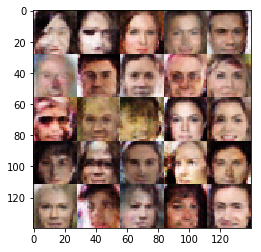

epoch 1 of 1 - generator loss: 0.337 discriminator loss: 1.711 
epoch 1 of 1 - generator loss: 0.469 discriminator loss: 1.502 
epoch 1 of 1 - generator loss: 0.593 discriminator loss: 1.403 
epoch 1 of 1 - generator loss: 0.523 discriminator loss: 1.452 
epoch 1 of 1 - generator loss: 0.631 discriminator loss: 1.299 
epoch 1 of 1 - generator loss: 0.391 discriminator loss: 1.627 
epoch 1 of 1 - generator loss: 0.633 discriminator loss: 1.338 
epoch 1 of 1 - generator loss: 0.555 discriminator loss: 1.397 
epoch 1 of 1 - generator loss: 0.807 discriminator loss: 1.472 
epoch 1 of 1 - generator loss: 0.707 discriminator loss: 1.398 


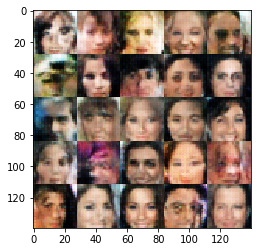

epoch 1 of 1 - generator loss: 0.880 discriminator loss: 1.233 
epoch 1 of 1 - generator loss: 0.786 discriminator loss: 1.404 
epoch 1 of 1 - generator loss: 0.708 discriminator loss: 1.278 
epoch 1 of 1 - generator loss: 0.760 discriminator loss: 1.241 
epoch 1 of 1 - generator loss: 0.452 discriminator loss: 1.519 
epoch 1 of 1 - generator loss: 0.505 discriminator loss: 1.530 
epoch 1 of 1 - generator loss: 0.635 discriminator loss: 1.355 
epoch 1 of 1 - generator loss: 0.614 discriminator loss: 1.426 
epoch 1 of 1 - generator loss: 0.437 discriminator loss: 1.623 
epoch 1 of 1 - generator loss: 0.653 discriminator loss: 1.343 


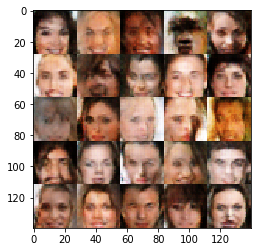

epoch 1 of 1 - generator loss: 0.492 discriminator loss: 1.433 
epoch 1 of 1 - generator loss: 0.645 discriminator loss: 1.361 
epoch 1 of 1 - generator loss: 1.147 discriminator loss: 1.313 
epoch 1 of 1 - generator loss: 0.995 discriminator loss: 1.291 
epoch 1 of 1 - generator loss: 0.670 discriminator loss: 1.449 
epoch 1 of 1 - generator loss: 0.783 discriminator loss: 1.164 
epoch 1 of 1 - generator loss: 0.697 discriminator loss: 1.278 
epoch 1 of 1 - generator loss: 0.305 discriminator loss: 1.817 
epoch 1 of 1 - generator loss: 0.457 discriminator loss: 1.494 
epoch 1 of 1 - generator loss: 0.789 discriminator loss: 1.246 


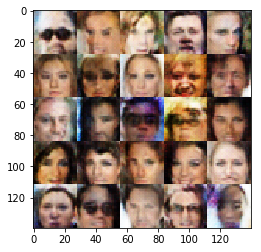

epoch 1 of 1 - generator loss: 0.745 discriminator loss: 1.278 
epoch 1 of 1 - generator loss: 0.505 discriminator loss: 1.408 
epoch 1 of 1 - generator loss: 0.749 discriminator loss: 1.283 
epoch 1 of 1 - generator loss: 0.616 discriminator loss: 1.356 
epoch 1 of 1 - generator loss: 0.503 discriminator loss: 1.454 
epoch 1 of 1 - generator loss: 0.674 discriminator loss: 1.328 
epoch 1 of 1 - generator loss: 0.925 discriminator loss: 1.383 
epoch 1 of 1 - generator loss: 0.452 discriminator loss: 1.497 
epoch 1 of 1 - generator loss: 0.479 discriminator loss: 1.522 
epoch 1 of 1 - generator loss: 0.513 discriminator loss: 1.435 


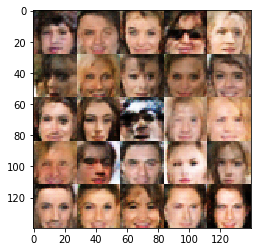

epoch 1 of 1 - generator loss: 0.804 discriminator loss: 1.356 
epoch 1 of 1 - generator loss: 0.786 discriminator loss: 1.360 
epoch 1 of 1 - generator loss: 0.526 discriminator loss: 1.391 
epoch 1 of 1 - generator loss: 0.584 discriminator loss: 1.446 
epoch 1 of 1 - generator loss: 0.709 discriminator loss: 1.323 
epoch 1 of 1 - generator loss: 0.801 discriminator loss: 1.157 
epoch 1 of 1 - generator loss: 0.860 discriminator loss: 1.301 
epoch 1 of 1 - generator loss: 0.574 discriminator loss: 1.411 
epoch 1 of 1 - generator loss: 0.929 discriminator loss: 1.443 
epoch 1 of 1 - generator loss: 0.630 discriminator loss: 1.383 


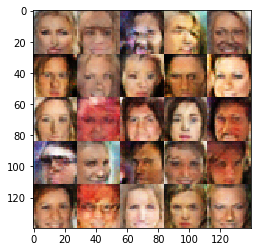

epoch 1 of 1 - generator loss: 0.823 discriminator loss: 1.557 
epoch 1 of 1 - generator loss: 0.352 discriminator loss: 1.663 
epoch 1 of 1 - generator loss: 0.854 discriminator loss: 1.386 
epoch 1 of 1 - generator loss: 0.559 discriminator loss: 1.413 
epoch 1 of 1 - generator loss: 0.586 discriminator loss: 1.319 
epoch 1 of 1 - generator loss: 0.589 discriminator loss: 1.408 
epoch 1 of 1 - generator loss: 0.462 discriminator loss: 1.604 
epoch 1 of 1 - generator loss: 0.623 discriminator loss: 1.341 
epoch 1 of 1 - generator loss: 0.599 discriminator loss: 1.407 
epoch 1 of 1 - generator loss: 0.689 discriminator loss: 1.205 


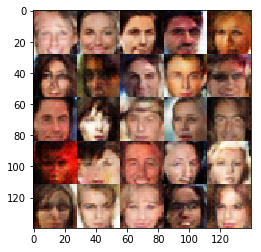

epoch 1 of 1 - generator loss: 0.454 discriminator loss: 1.439 
epoch 1 of 1 - generator loss: 0.466 discriminator loss: 1.518 
epoch 1 of 1 - generator loss: 0.421 discriminator loss: 1.572 
epoch 1 of 1 - generator loss: 0.442 discriminator loss: 1.635 
epoch 1 of 1 - generator loss: 0.617 discriminator loss: 1.287 
epoch 1 of 1 - generator loss: 0.764 discriminator loss: 1.201 
epoch 1 of 1 - generator loss: 0.581 discriminator loss: 1.378 
epoch 1 of 1 - generator loss: 0.664 discriminator loss: 1.293 
epoch 1 of 1 - generator loss: 0.468 discriminator loss: 1.615 
epoch 1 of 1 - generator loss: 0.618 discriminator loss: 1.436 


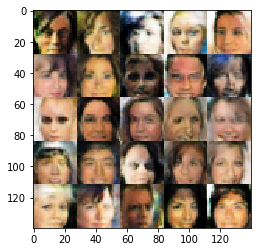

epoch 1 of 1 - generator loss: 0.549 discriminator loss: 1.395 
epoch 1 of 1 - generator loss: 0.467 discriminator loss: 1.502 
epoch 1 of 1 - generator loss: 0.646 discriminator loss: 1.389 
epoch 1 of 1 - generator loss: 0.759 discriminator loss: 1.178 
epoch 1 of 1 - generator loss: 0.514 discriminator loss: 1.444 
epoch 1 of 1 - generator loss: 0.626 discriminator loss: 1.355 
epoch 1 of 1 - generator loss: 0.670 discriminator loss: 1.427 
epoch 1 of 1 - generator loss: 0.630 discriminator loss: 1.296 
epoch 1 of 1 - generator loss: 0.578 discriminator loss: 1.363 
epoch 1 of 1 - generator loss: 0.335 discriminator loss: 1.707 


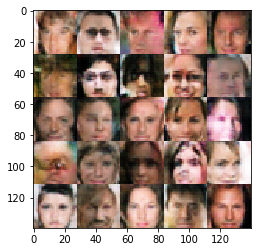

epoch 1 of 1 - generator loss: 0.589 discriminator loss: 1.437 
epoch 1 of 1 - generator loss: 0.591 discriminator loss: 1.363 
epoch 1 of 1 - generator loss: 0.650 discriminator loss: 1.258 
epoch 1 of 1 - generator loss: 0.661 discriminator loss: 1.355 
epoch 1 of 1 - generator loss: 0.606 discriminator loss: 1.446 
epoch 1 of 1 - generator loss: 0.552 discriminator loss: 1.452 
epoch 1 of 1 - generator loss: 0.594 discriminator loss: 1.454 
epoch 1 of 1 - generator loss: 0.665 discriminator loss: 1.408 
epoch 1 of 1 - generator loss: 0.451 discriminator loss: 1.572 
epoch 1 of 1 - generator loss: 0.667 discriminator loss: 1.373 


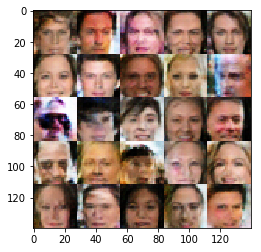

epoch 1 of 1 - generator loss: 0.735 discriminator loss: 1.410 
epoch 1 of 1 - generator loss: 1.066 discriminator loss: 1.384 
epoch 1 of 1 - generator loss: 0.404 discriminator loss: 1.566 
epoch 1 of 1 - generator loss: 0.802 discriminator loss: 1.217 
epoch 1 of 1 - generator loss: 0.525 discriminator loss: 1.388 
epoch 1 of 1 - generator loss: 0.687 discriminator loss: 1.364 
epoch 1 of 1 - generator loss: 0.508 discriminator loss: 1.625 
epoch 1 of 1 - generator loss: 1.217 discriminator loss: 1.236 
epoch 1 of 1 - generator loss: 0.655 discriminator loss: 1.399 
epoch 1 of 1 - generator loss: 0.500 discriminator loss: 1.565 


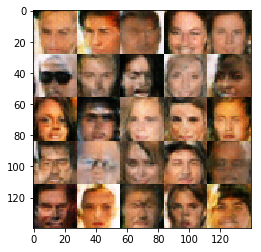

epoch 1 of 1 - generator loss: 0.597 discriminator loss: 1.322 
epoch 1 of 1 - generator loss: 0.803 discriminator loss: 1.199 
epoch 1 of 1 - generator loss: 0.457 discriminator loss: 1.499 
epoch 1 of 1 - generator loss: 0.769 discriminator loss: 1.352 
epoch 1 of 1 - generator loss: 0.843 discriminator loss: 1.232 
epoch 1 of 1 - generator loss: 0.451 discriminator loss: 1.454 
epoch 1 of 1 - generator loss: 0.857 discriminator loss: 1.286 
epoch 1 of 1 - generator loss: 0.449 discriminator loss: 1.599 
epoch 1 of 1 - generator loss: 0.561 discriminator loss: 1.395 
epoch 1 of 1 - generator loss: 0.560 discriminator loss: 1.355 


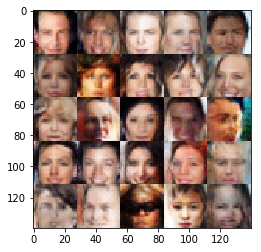

epoch 1 of 1 - generator loss: 0.591 discriminator loss: 1.373 
epoch 1 of 1 - generator loss: 0.702 discriminator loss: 1.320 
epoch 1 of 1 - generator loss: 0.629 discriminator loss: 1.335 
epoch 1 of 1 - generator loss: 0.546 discriminator loss: 1.333 
epoch 1 of 1 - generator loss: 0.531 discriminator loss: 1.466 
epoch 1 of 1 - generator loss: 0.472 discriminator loss: 1.415 
epoch 1 of 1 - generator loss: 0.891 discriminator loss: 1.193 
epoch 1 of 1 - generator loss: 0.585 discriminator loss: 1.378 
epoch 1 of 1 - generator loss: 0.959 discriminator loss: 1.176 
epoch 1 of 1 - generator loss: 0.767 discriminator loss: 1.326 


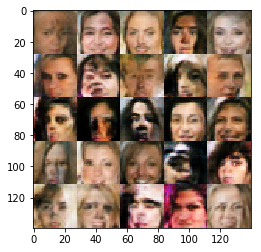

epoch 1 of 1 - generator loss: 1.087 discriminator loss: 1.257 
epoch 1 of 1 - generator loss: 0.578 discriminator loss: 1.390 
epoch 1 of 1 - generator loss: 0.733 discriminator loss: 1.242 
epoch 1 of 1 - generator loss: 0.872 discriminator loss: 1.336 
epoch 1 of 1 - generator loss: 0.678 discriminator loss: 1.263 
epoch 1 of 1 - generator loss: 0.447 discriminator loss: 1.564 
epoch 1 of 1 - generator loss: 0.790 discriminator loss: 1.394 
epoch 1 of 1 - generator loss: 0.935 discriminator loss: 1.342 
epoch 1 of 1 - generator loss: 0.401 discriminator loss: 1.654 
epoch 1 of 1 - generator loss: 0.976 discriminator loss: 1.278 


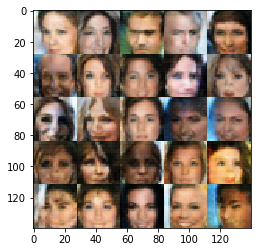

epoch 1 of 1 - generator loss: 0.407 discriminator loss: 1.628 
epoch 1 of 1 - generator loss: 0.693 discriminator loss: 1.251 
epoch 1 of 1 - generator loss: 0.690 discriminator loss: 1.483 
epoch 1 of 1 - generator loss: 0.513 discriminator loss: 1.379 
epoch 1 of 1 - generator loss: 0.575 discriminator loss: 1.388 
epoch 1 of 1 - generator loss: 0.586 discriminator loss: 1.334 
epoch 1 of 1 - generator loss: 0.724 discriminator loss: 1.236 
epoch 1 of 1 - generator loss: 0.548 discriminator loss: 1.425 
epoch 1 of 1 - generator loss: 0.314 discriminator loss: 1.825 
epoch 1 of 1 - generator loss: 0.618 discriminator loss: 1.345 


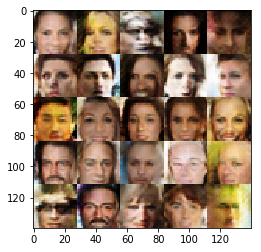

epoch 1 of 1 - generator loss: 0.695 discriminator loss: 1.365 
epoch 1 of 1 - generator loss: 0.857 discriminator loss: 1.300 
epoch 1 of 1 - generator loss: 0.725 discriminator loss: 1.417 
epoch 1 of 1 - generator loss: 0.520 discriminator loss: 1.414 
epoch 1 of 1 - generator loss: 0.545 discriminator loss: 1.422 
epoch 1 of 1 - generator loss: 1.160 discriminator loss: 1.107 
epoch 1 of 1 - generator loss: 0.498 discriminator loss: 1.526 
epoch 1 of 1 - generator loss: 0.477 discriminator loss: 1.640 
epoch 1 of 1 - generator loss: 1.008 discriminator loss: 1.177 
epoch 1 of 1 - generator loss: 0.566 discriminator loss: 1.365 


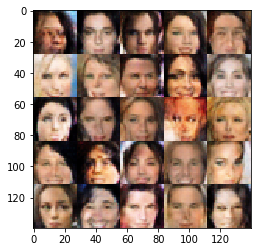

epoch 1 of 1 - generator loss: 1.026 discriminator loss: 1.486 
epoch 1 of 1 - generator loss: 0.771 discriminator loss: 1.203 
epoch 1 of 1 - generator loss: 0.442 discriminator loss: 1.523 
epoch 1 of 1 - generator loss: 0.651 discriminator loss: 1.326 
epoch 1 of 1 - generator loss: 0.729 discriminator loss: 1.410 
epoch 1 of 1 - generator loss: 0.776 discriminator loss: 1.203 
epoch 1 of 1 - generator loss: 0.378 discriminator loss: 1.829 
epoch 1 of 1 - generator loss: 0.587 discriminator loss: 1.468 
epoch 1 of 1 - generator loss: 0.663 discriminator loss: 1.449 
epoch 1 of 1 - generator loss: 0.683 discriminator loss: 1.293 


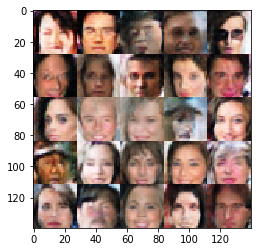

epoch 1 of 1 - generator loss: 0.563 discriminator loss: 1.454 
epoch 1 of 1 - generator loss: 0.558 discriminator loss: 1.427 
epoch 1 of 1 - generator loss: 0.467 discriminator loss: 1.484 
epoch 1 of 1 - generator loss: 0.666 discriminator loss: 1.484 
epoch 1 of 1 - generator loss: 0.824 discriminator loss: 1.274 
epoch 1 of 1 - generator loss: 0.578 discriminator loss: 1.376 
epoch 1 of 1 - generator loss: 0.554 discriminator loss: 1.454 
epoch 1 of 1 - generator loss: 1.186 discriminator loss: 1.096 
epoch 1 of 1 - generator loss: 0.575 discriminator loss: 1.391 
epoch 1 of 1 - generator loss: 0.353 discriminator loss: 1.624 


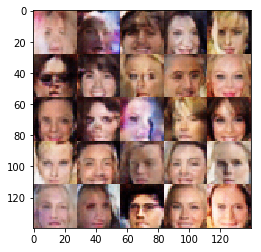

epoch 1 of 1 - generator loss: 0.855 discriminator loss: 1.205 
epoch 1 of 1 - generator loss: 0.601 discriminator loss: 1.441 
epoch 1 of 1 - generator loss: 0.532 discriminator loss: 1.402 
epoch 1 of 1 - generator loss: 0.528 discriminator loss: 1.459 
epoch 1 of 1 - generator loss: 0.565 discriminator loss: 1.372 
epoch 1 of 1 - generator loss: 0.473 discriminator loss: 1.875 
epoch 1 of 1 - generator loss: 0.487 discriminator loss: 1.506 
epoch 1 of 1 - generator loss: 0.532 discriminator loss: 1.430 
epoch 1 of 1 - generator loss: 0.740 discriminator loss: 1.222 
epoch 1 of 1 - generator loss: 0.507 discriminator loss: 1.401 


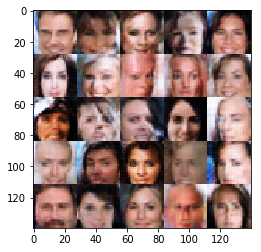

epoch 1 of 1 - generator loss: 0.363 discriminator loss: 1.765 
epoch 1 of 1 - generator loss: 0.819 discriminator loss: 1.379 
epoch 1 of 1 - generator loss: 0.590 discriminator loss: 1.424 
epoch 1 of 1 - generator loss: 0.630 discriminator loss: 1.261 
epoch 1 of 1 - generator loss: 0.643 discriminator loss: 1.248 
epoch 1 of 1 - generator loss: 0.712 discriminator loss: 1.339 
epoch 1 of 1 - generator loss: 0.661 discriminator loss: 1.319 
epoch 1 of 1 - generator loss: 0.451 discriminator loss: 1.523 
epoch 1 of 1 - generator loss: 0.641 discriminator loss: 1.387 
epoch 1 of 1 - generator loss: 0.473 discriminator loss: 1.496 


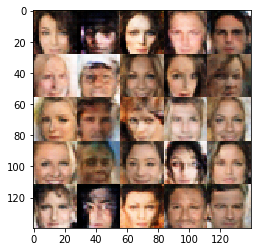

epoch 1 of 1 - generator loss: 0.392 discriminator loss: 1.554 
epoch 1 of 1 - generator loss: 0.651 discriminator loss: 1.294 
epoch 1 of 1 - generator loss: 0.480 discriminator loss: 1.591 
epoch 1 of 1 - generator loss: 0.321 discriminator loss: 1.713 
epoch 1 of 1 - generator loss: 0.814 discriminator loss: 1.214 
epoch 1 of 1 - generator loss: 0.353 discriminator loss: 1.743 
epoch 1 of 1 - generator loss: 0.677 discriminator loss: 1.301 
epoch 1 of 1 - generator loss: 0.680 discriminator loss: 1.310 
epoch 1 of 1 - generator loss: 0.399 discriminator loss: 1.625 
epoch 1 of 1 - generator loss: 0.437 discriminator loss: 1.522 


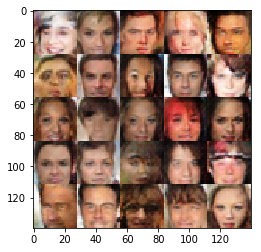

epoch 1 of 1 - generator loss: 0.516 discriminator loss: 1.497 
epoch 1 of 1 - generator loss: 0.408 discriminator loss: 1.654 
epoch 1 of 1 - generator loss: 0.881 discriminator loss: 1.139 
epoch 1 of 1 - generator loss: 0.756 discriminator loss: 1.092 
epoch 1 of 1 - generator loss: 0.506 discriminator loss: 1.475 
epoch 1 of 1 - generator loss: 0.633 discriminator loss: 1.290 
epoch 1 of 1 - generator loss: 0.316 discriminator loss: 1.776 
epoch 1 of 1 - generator loss: 0.566 discriminator loss: 1.370 
epoch 1 of 1 - generator loss: 0.412 discriminator loss: 1.614 
epoch 1 of 1 - generator loss: 0.653 discriminator loss: 1.242 


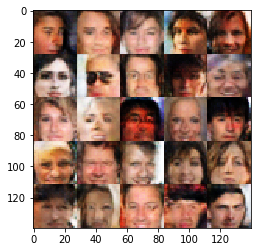

epoch 1 of 1 - generator loss: 0.719 discriminator loss: 1.481 
epoch 1 of 1 - generator loss: 0.818 discriminator loss: 1.294 
epoch 1 of 1 - generator loss: 0.647 discriminator loss: 1.242 
epoch 1 of 1 - generator loss: 0.749 discriminator loss: 1.294 
epoch 1 of 1 - generator loss: 0.319 discriminator loss: 1.711 
epoch 1 of 1 - generator loss: 0.497 discriminator loss: 1.553 
epoch 1 of 1 - generator loss: 0.513 discriminator loss: 1.307 
epoch 1 of 1 - generator loss: 0.854 discriminator loss: 1.177 
epoch 1 of 1 - generator loss: 0.999 discriminator loss: 1.057 
epoch 1 of 1 - generator loss: 1.147 discriminator loss: 0.860 


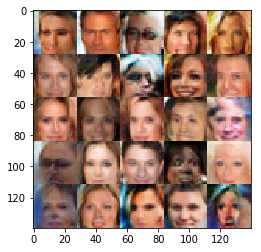

epoch 1 of 1 - generator loss: 0.691 discriminator loss: 1.328 
epoch 1 of 1 - generator loss: 0.790 discriminator loss: 1.275 
epoch 1 of 1 - generator loss: 0.539 discriminator loss: 1.352 
epoch 1 of 1 - generator loss: 0.615 discriminator loss: 1.613 
epoch 1 of 1 - generator loss: 0.545 discriminator loss: 1.350 
epoch 1 of 1 - generator loss: 0.448 discriminator loss: 1.591 
epoch 1 of 1 - generator loss: 0.737 discriminator loss: 1.329 
epoch 1 of 1 - generator loss: 0.507 discriminator loss: 1.514 
epoch 1 of 1 - generator loss: 0.217 discriminator loss: 2.020 
epoch 1 of 1 - generator loss: 0.938 discriminator loss: 1.403 


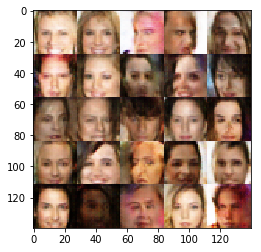

epoch 1 of 1 - generator loss: 0.451 discriminator loss: 1.621 
epoch 1 of 1 - generator loss: 0.705 discriminator loss: 1.241 
epoch 1 of 1 - generator loss: 0.671 discriminator loss: 1.274 
epoch 1 of 1 - generator loss: 1.183 discriminator loss: 1.199 
epoch 1 of 1 - generator loss: 0.354 discriminator loss: 1.824 
epoch 1 of 1 - generator loss: 0.699 discriminator loss: 1.331 
epoch 1 of 1 - generator loss: 0.681 discriminator loss: 1.316 
epoch 1 of 1 - generator loss: 0.553 discriminator loss: 1.344 
epoch 1 of 1 - generator loss: 0.602 discriminator loss: 1.311 
epoch 1 of 1 - generator loss: 0.606 discriminator loss: 1.241 


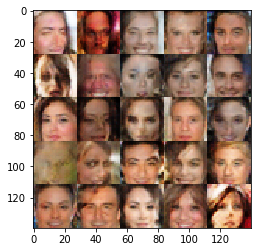

epoch 1 of 1 - generator loss: 0.481 discriminator loss: 1.425 
epoch 1 of 1 - generator loss: 0.566 discriminator loss: 1.410 
epoch 1 of 1 - generator loss: 0.739 discriminator loss: 1.173 
epoch 1 of 1 - generator loss: 0.699 discriminator loss: 1.447 
epoch 1 of 1 - generator loss: 0.412 discriminator loss: 1.634 
epoch 1 of 1 - generator loss: 0.176 discriminator loss: 2.308 
epoch 1 of 1 - generator loss: 0.654 discriminator loss: 1.417 
epoch 1 of 1 - generator loss: 0.951 discriminator loss: 1.209 
epoch 1 of 1 - generator loss: 0.684 discriminator loss: 1.245 
epoch 1 of 1 - generator loss: 0.467 discriminator loss: 1.540 


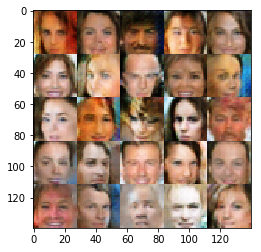

epoch 1 of 1 - generator loss: 0.639 discriminator loss: 1.285 
epoch 1 of 1 - generator loss: 0.502 discriminator loss: 1.499 
epoch 1 of 1 - generator loss: 0.480 discriminator loss: 1.533 
epoch 1 of 1 - generator loss: 0.728 discriminator loss: 1.405 
epoch 1 of 1 - generator loss: 0.408 discriminator loss: 1.533 
epoch 1 of 1 - generator loss: 0.536 discriminator loss: 1.337 
epoch 1 of 1 - generator loss: 0.580 discriminator loss: 1.417 
epoch 1 of 1 - generator loss: 0.506 discriminator loss: 1.341 
epoch 1 of 1 - generator loss: 0.778 discriminator loss: 1.222 
epoch 1 of 1 - generator loss: 0.648 discriminator loss: 1.388 


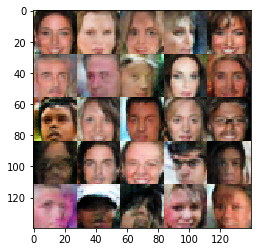

epoch 1 of 1 - generator loss: 0.359 discriminator loss: 1.684 
epoch 1 of 1 - generator loss: 0.426 discriminator loss: 1.621 
epoch 1 of 1 - generator loss: 0.447 discriminator loss: 1.673 
epoch 1 of 1 - generator loss: 0.777 discriminator loss: 1.274 
epoch 1 of 1 - generator loss: 0.880 discriminator loss: 1.075 
epoch 1 of 1 - generator loss: 0.803 discriminator loss: 1.265 
epoch 1 of 1 - generator loss: 0.606 discriminator loss: 1.587 
epoch 1 of 1 - generator loss: 0.532 discriminator loss: 1.467 
epoch 1 of 1 - generator loss: 0.378 discriminator loss: 1.730 
epoch 1 of 1 - generator loss: 0.569 discriminator loss: 1.406 


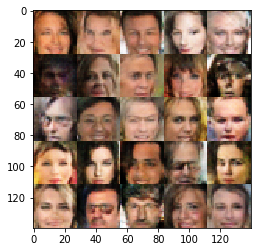

epoch 1 of 1 - generator loss: 0.462 discriminator loss: 1.512 
epoch 1 of 1 - generator loss: 0.392 discriminator loss: 1.679 
epoch 1 of 1 - generator loss: 0.815 discriminator loss: 1.354 
epoch 1 of 1 - generator loss: 0.569 discriminator loss: 1.429 
epoch 1 of 1 - generator loss: 0.728 discriminator loss: 1.302 
epoch 1 of 1 - generator loss: 0.923 discriminator loss: 1.205 
epoch 1 of 1 - generator loss: 0.452 discriminator loss: 1.514 
epoch 1 of 1 - generator loss: 0.784 discriminator loss: 1.338 
epoch 1 of 1 - generator loss: 0.610 discriminator loss: 1.329 
epoch 1 of 1 - generator loss: 0.432 discriminator loss: 1.613 


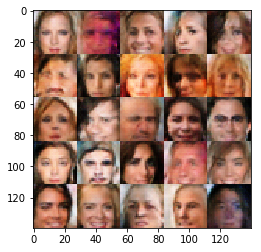

epoch 1 of 1 - generator loss: 0.725 discriminator loss: 1.233 
epoch 1 of 1 - generator loss: 0.580 discriminator loss: 1.354 
epoch 1 of 1 - generator loss: 0.331 discriminator loss: 1.676 
epoch 1 of 1 - generator loss: 0.564 discriminator loss: 1.485 
epoch 1 of 1 - generator loss: 1.048 discriminator loss: 1.485 
epoch 1 of 1 - generator loss: 0.524 discriminator loss: 1.446 
epoch 1 of 1 - generator loss: 0.951 discriminator loss: 1.152 
epoch 1 of 1 - generator loss: 0.558 discriminator loss: 1.482 
epoch 1 of 1 - generator loss: 0.361 discriminator loss: 1.687 
epoch 1 of 1 - generator loss: 0.492 discriminator loss: 1.427 


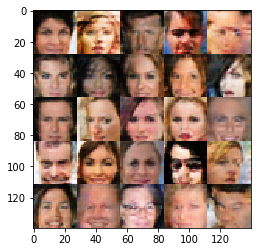

epoch 1 of 1 - generator loss: 0.558 discriminator loss: 1.550 
epoch 1 of 1 - generator loss: 0.705 discriminator loss: 1.346 
epoch 1 of 1 - generator loss: 0.370 discriminator loss: 1.590 
epoch 1 of 1 - generator loss: 0.282 discriminator loss: 1.812 
epoch 1 of 1 - generator loss: 0.854 discriminator loss: 1.183 
epoch 1 of 1 - generator loss: 0.560 discriminator loss: 1.358 
epoch 1 of 1 - generator loss: 0.653 discriminator loss: 1.417 
epoch 1 of 1 - generator loss: 0.674 discriminator loss: 1.325 
epoch 1 of 1 - generator loss: 0.613 discriminator loss: 1.452 
epoch 1 of 1 - generator loss: 0.529 discriminator loss: 1.360 


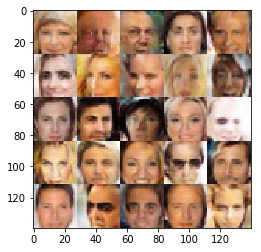

epoch 1 of 1 - generator loss: 0.670 discriminator loss: 1.291 
epoch 1 of 1 - generator loss: 0.580 discriminator loss: 1.385 
epoch 1 of 1 - generator loss: 0.915 discriminator loss: 1.191 
epoch 1 of 1 - generator loss: 0.679 discriminator loss: 1.395 
epoch 1 of 1 - generator loss: 0.541 discriminator loss: 1.399 
epoch 1 of 1 - generator loss: 0.675 discriminator loss: 1.397 
epoch 1 of 1 - generator loss: 0.915 discriminator loss: 1.156 
epoch 1 of 1 - generator loss: 0.408 discriminator loss: 1.595 
epoch 1 of 1 - generator loss: 0.625 discriminator loss: 1.324 
epoch 1 of 1 - generator loss: 0.546 discriminator loss: 1.405 


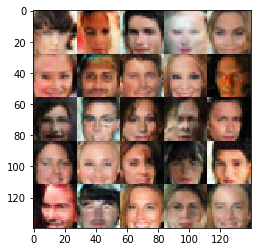

epoch 1 of 1 - generator loss: 0.387 discriminator loss: 1.640 
epoch 1 of 1 - generator loss: 0.472 discriminator loss: 1.616 
epoch 1 of 1 - generator loss: 0.405 discriminator loss: 1.644 
epoch 1 of 1 - generator loss: 0.903 discriminator loss: 1.263 
epoch 1 of 1 - generator loss: 0.430 discriminator loss: 1.490 
epoch 1 of 1 - generator loss: 0.761 discriminator loss: 1.263 
epoch 1 of 1 - generator loss: 0.886 discriminator loss: 1.163 
epoch 1 of 1 - generator loss: 0.700 discriminator loss: 1.275 
epoch 1 of 1 - generator loss: 0.538 discriminator loss: 1.379 
epoch 1 of 1 - generator loss: 0.601 discriminator loss: 1.245 


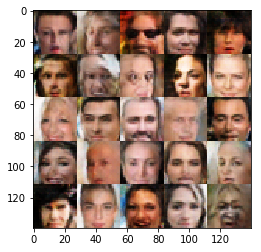

epoch 1 of 1 - generator loss: 0.378 discriminator loss: 1.634 
epoch 1 of 1 - generator loss: 0.667 discriminator loss: 1.218 
epoch 1 of 1 - generator loss: 0.785 discriminator loss: 1.437 
epoch 1 of 1 - generator loss: 0.679 discriminator loss: 1.406 
epoch 1 of 1 - generator loss: 0.838 discriminator loss: 1.102 
epoch 1 of 1 - generator loss: 0.863 discriminator loss: 1.070 
epoch 1 of 1 - generator loss: 0.691 discriminator loss: 1.157 
epoch 1 of 1 - generator loss: 0.621 discriminator loss: 1.435 
epoch 1 of 1 - generator loss: 0.415 discriminator loss: 1.597 
epoch 1 of 1 - generator loss: 0.313 discriminator loss: 1.776 


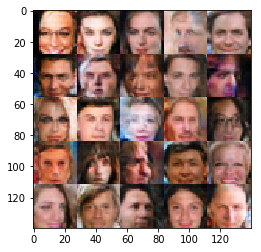

epoch 1 of 1 - generator loss: 0.875 discriminator loss: 1.241 
epoch 1 of 1 - generator loss: 1.100 discriminator loss: 1.051 
epoch 1 of 1 - generator loss: 0.404 discriminator loss: 1.590 
epoch 1 of 1 - generator loss: 0.507 discriminator loss: 1.379 
epoch 1 of 1 - generator loss: 0.461 discriminator loss: 1.472 
epoch 1 of 1 - generator loss: 0.572 discriminator loss: 1.329 
epoch 1 of 1 - generator loss: 0.550 discriminator loss: 1.348 
epoch 1 of 1 - generator loss: 0.653 discriminator loss: 1.305 
epoch 1 of 1 - generator loss: 0.521 discriminator loss: 1.385 
epoch 1 of 1 - generator loss: 0.653 discriminator loss: 1.469 


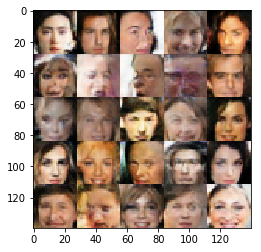

epoch 1 of 1 - generator loss: 0.749 discriminator loss: 1.204 
epoch 1 of 1 - generator loss: 0.820 discriminator loss: 1.168 
epoch 1 of 1 - generator loss: 0.834 discriminator loss: 1.155 
epoch 1 of 1 - generator loss: 0.762 discriminator loss: 1.135 
epoch 1 of 1 - generator loss: 0.666 discriminator loss: 1.239 
epoch 1 of 1 - generator loss: 0.784 discriminator loss: 1.253 
epoch 1 of 1 - generator loss: 0.504 discriminator loss: 1.512 
epoch 1 of 1 - generator loss: 0.728 discriminator loss: 1.188 
epoch 1 of 1 - generator loss: 0.881 discriminator loss: 1.203 
epoch 1 of 1 - generator loss: 0.973 discriminator loss: 1.042 


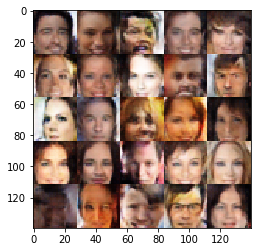

epoch 1 of 1 - generator loss: 0.758 discriminator loss: 1.378 
epoch 1 of 1 - generator loss: 0.656 discriminator loss: 1.247 
epoch 1 of 1 - generator loss: 0.815 discriminator loss: 1.072 
epoch 1 of 1 - generator loss: 0.698 discriminator loss: 1.198 
epoch 1 of 1 - generator loss: 0.493 discriminator loss: 1.475 
epoch 1 of 1 - generator loss: 0.475 discriminator loss: 1.457 
epoch 1 of 1 - generator loss: 0.471 discriminator loss: 1.655 
epoch 1 of 1 - generator loss: 0.375 discriminator loss: 1.690 
epoch 1 of 1 - generator loss: 0.769 discriminator loss: 1.263 
epoch 1 of 1 - generator loss: 0.415 discriminator loss: 1.645 


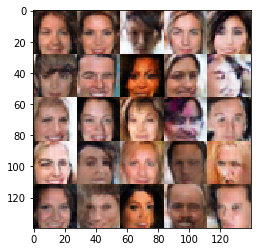

epoch 1 of 1 - generator loss: 0.443 discriminator loss: 1.600 
epoch 1 of 1 - generator loss: 0.470 discriminator loss: 1.469 
epoch 1 of 1 - generator loss: 0.620 discriminator loss: 1.314 
epoch 1 of 1 - generator loss: 0.351 discriminator loss: 1.720 
epoch 1 of 1 - generator loss: 0.605 discriminator loss: 1.661 
epoch 1 of 1 - generator loss: 0.611 discriminator loss: 1.282 
epoch 1 of 1 - generator loss: 0.543 discriminator loss: 1.326 
epoch 1 of 1 - generator loss: 0.723 discriminator loss: 1.348 
epoch 1 of 1 - generator loss: 0.663 discriminator loss: 1.235 
epoch 1 of 1 - generator loss: 0.681 discriminator loss: 1.388 


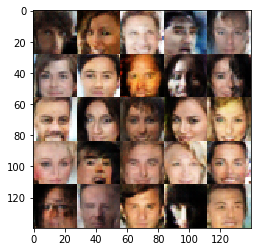

epoch 1 of 1 - generator loss: 0.469 discriminator loss: 1.530 
epoch 1 of 1 - generator loss: 0.538 discriminator loss: 1.408 
epoch 1 of 1 - generator loss: 0.562 discriminator loss: 1.353 
epoch 1 of 1 - generator loss: 0.402 discriminator loss: 1.555 
epoch 1 of 1 - generator loss: 0.597 discriminator loss: 1.200 
epoch 1 of 1 - generator loss: 1.079 discriminator loss: 0.963 
epoch 1 of 1 - generator loss: 0.336 discriminator loss: 1.791 
epoch 1 of 1 - generator loss: 0.863 discriminator loss: 1.113 
epoch 1 of 1 - generator loss: 0.640 discriminator loss: 1.237 
epoch 1 of 1 - generator loss: 0.340 discriminator loss: 1.717 


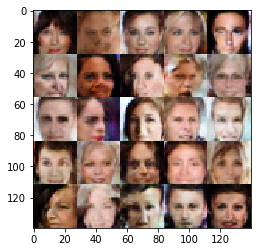

epoch 1 of 1 - generator loss: 0.612 discriminator loss: 1.286 
epoch 1 of 1 - generator loss: 0.531 discriminator loss: 1.311 
epoch 1 of 1 - generator loss: 0.510 discriminator loss: 1.440 
epoch 1 of 1 - generator loss: 0.825 discriminator loss: 1.091 
epoch 1 of 1 - generator loss: 0.368 discriminator loss: 1.810 
epoch 1 of 1 - generator loss: 0.358 discriminator loss: 1.649 
epoch 1 of 1 - generator loss: 0.690 discriminator loss: 1.316 
epoch 1 of 1 - generator loss: 0.601 discriminator loss: 1.587 
epoch 1 of 1 - generator loss: 0.475 discriminator loss: 1.504 
epoch 1 of 1 - generator loss: 0.443 discriminator loss: 1.568 


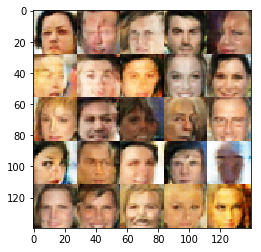

epoch 1 of 1 - generator loss: 0.890 discriminator loss: 1.064 
epoch 1 of 1 - generator loss: 0.561 discriminator loss: 1.434 
epoch 1 of 1 - generator loss: 0.349 discriminator loss: 1.742 
Final output:


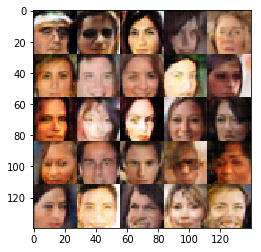

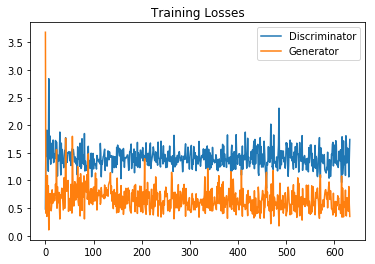

In [152]:
batch_size = 32
z_dim = 100
learning_rate = 0.0008
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.